# Implementing transfer learning on Vgg16 using pyTorch

Hi! I am  [Jean-Nicolas Jérémie](https://laurentperrinet.github.io/author/jean-nicolas-jeremie/) and the goal of this notebook is to provide a framework to implement (and experiment with) [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) on deep convolutional neuronal network (DCNN). In a nutshell, this method allows to re-use the knowlegde learned on a problem and applying it to a different (yet related) problem. It is interesting as it allows to implement complex task *de novo* quite reapidly (in a few hours) without having to retrain the millions of parameters of a DCNN (which takes days of computations). The basic hypothesis is that it suffices to re-train the last classification layers (the head) while keeping the first layers fixed.

In particular, we will start from a VGG16 network loaded from the `torchvision.models` library and pre-trained on the [Imagenet](http://image-net.org/) dataset wich allows to perform label detection on naturals images for $K = 1000$ labels. Our goal here will be to re-train the last fully-Connected layer of the network to perfom the same task but in a sub-set of $K = 10$ labels from the Imagenet dataset. 

Moreover, we are going to evaluate different strategies of transfer learning:

* VGG General : Substitute the last layer of the pyTorch VGG16 network ($K = 1000$ labels) with a new layer build from a specific subset ($K = 10$ labels).
* VGG Linear : Add a new layer build from a specific subset ($K = 10$ labels) after the last Fully-Connected layer of the the pyTorch VGG16 network.
* VGG Gray : Same architecture as the VGG General network but trained with grayscale images.
* VGG Scale : Same architecture as the VGG General network but trained with images of different size.

In this notebook, I will use the [pyTorch](https://pytorch.org/) library for running the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This notebook was done during a master 2 internship at the Neurosciences Institute of Timone (INT) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/). It is curated in the following [github repo](https://github.com/JNJER/2020-06-26_fast_and_curious.git).

<!-- TEASER_END -->

In our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html), as the VGG16 network was first trained on the entire dataset of $K=1000$ labels, and in order to recover the classification confidence predicted by the model according to the specific subset of classes ($K = 10$ labels) on which it is tested, the output `softmax` mathematical function of the last layer of the network was slightly changed. By assuming that we know *a priori* that the image belongs to one (and only one) category from the sub-set the probabilities obtained would correspond to a confidence of classification discriminating only the classes of interest and can be compared to a chance level of $1 /K$. This creates another network (which is not retrained) directly based on VGG:

* VGG Subset : Just consider the specific subset ($K = 10$ labels) from the last layer of the pyTorch VGG16 network ($K = 1000$ labels).

This notebook aims also to verify this hypothesis. Our use case consists of measuring whether there are differences in the likelihood of these networks during an image recognition task on a sub-set of $1000$ classes of the `ImageNet` library, with $K = 10$ (experiment 1). Additionally, we will implement some image transformations as up/down-sampling (experiment 2) or transforming to grayscale (experiment 3) to quantify their influence on the accuracy and computation time of each network.


*Some useful links :*

* https://jaketae.github.io/study/pytorch-vgg/
* https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
* https://www.kaggle.com/paultimothymooney/detect-retina-damage-from-oct-images/notebook

* https://en.wikipedia.org/wiki/Transfer_learning
* https://github.com/laurentperrinet/ImageNet-Datasets-Downloader/tree/8d1c0925b5512f48978177a76e7b851ff40acb7b

Let's first install requirements

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%mkdir -p DCNN_training_benchmark
%mkdir -p results
%mkdir -p models

## Initialization of the libraries/variables

Our coding strategy is to build up a small library as a package of scripts in the `DCNN_benchmark` folder and to run all calls to that library from this notebook. This follows our [previous work]( https://laurentperrinet.github.io/sciblog/posts/2020-09-28-benchmarking-cnns.html) in which we benchmarked various DCNNs and which allowed us to select VGG16 as a good compromise between performance and complexity.

First of all, a `init.py` script defines all our usefull variables like the new labels to learn, the number of training images or the root folder to use. Also, we import libraries to train the different networks and display the results.

In [3]:
scriptname = 'DCNN_training_benchmark/init.py'

In [4]:
%%writefile {scriptname}

# Importing libraries
import argparse
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np
#from numpy import random
import os
import requests
import time

from time import strftime, gmtime
datetag = strftime("%Y-%m-%d", gmtime())

#to plot & display 
def pprint(message): #display function
    print('-'*len(message))
    print(message)
    print('-'*len(message))
    
# to store results
import pandas as pd

# parse the root to the init module
def arg_parse():
    DEBUG = 10
    parser = argparse.ArgumentParser(description='DCNN_training_benchmark/init.py set root')
    parser.add_argument("--root", dest = 'root', help = 
                        "Directory containing images to perform the training",
                        default = 'data', type = str)
    parser.add_argument("--folders", dest = 'folders', help = 
                        "Set the training, validation and testing folders relative to the root",
                        default = ['test', 'val', 'train'], type = list)
    parser.add_argument("--HOST", dest = 'HOST', help = 
                    "Set the name of your machine",
                    default = os.uname()[1], type = str)
    parser.add_argument("--datetag", dest = 'datetag', help = 
                    "Set the datetag of the result's file",
                    default = datetag, type = str)
    parser.add_argument("--image_size", dest = 'image_size', help = 
                    "Set the image_size of the input",
                    default = 256)
    parser.add_argument("--image_sizes", dest = 'image_sizes', help = 
                    "Set the image_sizes of the input for experiment 2 (downscaling)",
                    default = 2**np.arange(6, 10), type = list)
    parser.add_argument("--N_images_train", dest = 'N_images_train', help = 
                    "Set the number of images per classe in the train folder",
                    default = 500//DEBUG)
    parser.add_argument("--N_images_val", dest = 'N_images_val', help = 
                    "Set the number of images per classe in the val folder",
                    default = 100//DEBUG)
    parser.add_argument("--N_images_test", dest = 'N_images_test', help = 
                    "Set the number of images per classe in the test folder",
                    default = 100//DEBUG)
    parser.add_argument("--num_epochs", dest = 'num_epochs', help = 
                    "Set the number of epoch to perform during the traitransportationning phase",
                    default = 50//DEBUG)
    parser.add_argument("--i_labels", dest = 'i_labels', help = 
                    "Set the labels of the classes (list of int)",
                    default = [945, 513, 886, 508, 786, 310, 373, 145, 146, 396], type = list)
    parser.add_argument("--class_loader", dest = 'class_loader', help = 
                        "Set the Directory containing imagenet downloaders class",
                        default = 'imagenet_label_to_wordnet_synset.json', type = str)
    parser.add_argument("--url_loader", dest = 'url_loader', help = 
                        "Set the file containing imagenet urls",
                        default = 'Imagenet_urls_ILSVRC_2016.json', type = str)
    parser.add_argument("--model_path", dest = 'model_path', help = 
                        "Set the path to the pre-trained model",
                        default = 'models/re-trained_', type = str)
    parser.add_argument("--model_names", dest = 'model_names', help = 
                        "Modes for the new trained networks",
                        default = ['vgg16_gray', 'vgg16_lin', 'vgg16_gen', 'vgg16_scale',], type = list)
    parser.add_argument("--resume_training", dest = 'resume_training', help = 
                        "--True to retrieve the latest model train",
                        default = False, type = bool)
    parser.add_argument("--train_scale", dest = 'train_scale', help = 
                        "--True to train vgg16_scale",
                        default = True, type = bool)
    parser.add_argument("--train_gray", dest = 'train_gray', help = 
                        "--True to train vgg16_gray",
                        default = True, type = bool)
    parser.add_argument("--train_base", dest = 'train_base', help = 
                        "--True to train vgg16_lin & vgg16_gen",
                        default = True, type = bool)
    return parser.parse_args()

args = arg_parse()
datetag = args.datetag
json_fname = os.path.join( datetag + '_config_args.json')
load_parse = False # False to custom the config

if load_parse:
    try:
        with open(json_fname, 'rt') as f:
            print(f'file {json_fname} exists: LOADING')
            override = json.load(f)
            args.__dict__.update(override)
    except:
        print(f'Creating file {json_fname}')
        with open(json_fname, 'wt') as f:
            json.dump(vars(args), f, indent=4)
else:
    print('Load config off')
    
# matplotlib parameters
colors = ['b', 'r', 'k', 'g', 'm']
fig_width = 20
phi = (np.sqrt(5)+1)/2 # golden ratio

# host variable 
HOST = args.HOST

#DCCN training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

# Select a device (CPU or CUDA)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('On date', datetag, ', Running benchmark on host', HOST, ' with device', device )

# Datasets Configuration
image_size = args.image_size # default image resolution
image_sizes =  args.image_sizes # resolutions explored in experiment 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transforms_norm =  transforms.Normalize(mean=mean, std=std) # to normalize colors on the imagenet dataset


i_labels = args.i_labels # Pre-selected classes
N_labels = len(i_labels)
id_dl = []

model_names = args.model_names
resume_training = args.resume_training #--True to retrieve the latest model train
train_scale = args.train_scale
train_gray = args.train_gray
train_base = args.train_base
num_epochs = args.num_epochs

model_path = args.model_path
model_paths = {}
root = args.root
folders = args.folders
paths = {}
reverse_id_labels = {}
N_images_per_class = {}
labels = []

for folder in folders :
    paths[folder] = os.path.join(root, folder) # data path
    if folder == 'train':
        N_images_per_class[folder] = args.N_images_train # choose the number of training pictures
    elif folder == 'val' : 
        N_images_per_class[folder] = args.N_images_val # choose the number of validation pictures
    else:
        N_images_per_class[folder] = args.N_images_test # choose the number of testing pictures 

with open(args.class_loader, 'r') as fp: # get all the classes on the data_downloader
    imagenet = json.load(fp)

# gathering labels
for a, img_id in enumerate(imagenet):
    reverse_id_labels[str('n' + (imagenet[img_id]['id'].replace('-n','')))] = imagenet[img_id]['label'].split(',')[0]
    labels.append(imagenet[img_id]['label'].split(',')[0])
    if int(img_id) in i_labels:
        id_dl.append('n' + (imagenet[img_id]['id'].replace('-n','')))    
        
# a reverse look-up-table giving the index of a given label (within the whole set of imagenet labels)
reverse_labels = {}
for i_label, label in enumerate(labels):
    reverse_labels[label] = i_label
# a reverse look-up-table giving the index of a given i_label (within the sub-set of classes)
reverse_i_labels = {}
for i_label, label in enumerate(i_labels):
    reverse_i_labels[label] = i_label
    
# a reverse look-up-table giving the label of a given index in the last layer of the new model (within the sub-set of classes)
reverse_model_labels = []
pprint('List of Pre-selected classes : ')
# choosing the selected classes for recognition
for i_label, id_ in zip(i_labels, id_dl) : 
    reverse_model_labels.append(labels[i_label])
    print('-> label', i_label, '=', labels[i_label], '\nid wordnet : ', id_)
reverse_model_labels.sort()

Overwriting DCNN_training_benchmark/init.py


In [5]:
%run {scriptname} 

Load config off
On date 2021-10-07 , Running benchmark on host inv-ope-de06  with device cuda:0
-------------------------------
List of Pre-selected classes : 
-------------------------------
-> label 945 = bell pepper 
id wordnet :  n02056570
-> label 513 = cornet 
id wordnet :  n02058221
-> label 886 = vending machine 
id wordnet :  n02219486
-> label 508 = computer keyboard 
id wordnet :  n02487347
-> label 786 = sewing machine 
id wordnet :  n02643566
-> label 310 = ant 
id wordnet :  n03085013
-> label 373 = macaque 
id wordnet :  n03110669
-> label 145 = king penguin 
id wordnet :  n04179913
-> label 146 = albatross 
id wordnet :  n04525305
-> label 396 = lionfish 
id wordnet :  n07720875


## Download the `train` & `val` dataset

In the `dataset.py`, we use an archive of the Imagenet fall 2011 urls to populate datasets based on the pre-selected classes listed in the `DCNN_benchmark/init.py` file. The following script is inspired by [previous work](https://github.com/laurentperrinet/ImageNet-Datasets-Downloader/) in our group.

In [68]:
scriptname = 'DCNN_training_benchmark/dataset.py'

In [69]:
%%writefile {scriptname}

from DCNN_training_benchmark.init import *  

from requests.exceptions import ConnectionError, ReadTimeout, TooManyRedirects, MissingSchema, InvalidURL

#IMG_EXT = ('jpg', 'jpeg', 'png', 'ppm', 'bmp', 'pgm', 'tif', 'tiff', 'webp')   
verbose = False 
save = True

#Imagenet_urls_ILSVRC_2016 = []
with open(args.url_loader) as json_file:
    Imagenet_urls_ILSVRC_2016 = json.load(json_file)

def clean_list(list_dir, patterns=['.DS_Store']):
    for pattern in patterns:
        if pattern in list_dir: list_dir.remove('.DS_Store')
    return list_dir
    
def get_image(img_url, class_folder):
    worked = 0
    to_save = True 
    if verbose:
        print(f'Processing {img_url}')

    if len(img_url) <= 1:
        to_save = False

    try:
        img_resp = requests.get(img_url, timeout = 1)
        
    except ConnectionError:
        if verbose :
            print(f"Connection Error for url {img_url}")
        return fail_get_image()

    except ReadTimeout:
        if verbose :
            print(f"Read Timeout for url {img_url}")
        return fail_get_image()
    
    except TooManyRedirects:
        if verbose :
            print(f"Too many redirects {img_url}")
        return fail_get_image()
    
    except MissingSchema:
        if verbose :
            print('MissingSchema failure')
        return fail_get_image()
    
    except InvalidURL:
        if verbose :
            print('InvalidURL failure')
        return fail_get_image()

    if not 'content-type' in img_resp.headers and to_save :
        if verbose :
            print('No content-type')
        to_save = False
    elif not 'image' in img_resp.headers['content-type'] and to_save :
        if verbose :
            print('Not an image')
        to_save = False
        
    if (len(img_resp.content) < 5000) and to_save :
        if verbose :
            print('Content to short')
        to_save = False

    img_name = img_url.split('/')[-1]
    img_name = img_name.split("?")[0]

    if (len(img_name) <= 1) and to_save:
        if verbose :
            print('Bad name for the image')
        to_save = False
    
    if 'jpe' in img_name or 'gif' in img_name :
        if verbose :
            print('Bad format for the image')
        to_save = False
    
    if img_name in os.listdir(class_folder):
        worked = 1
        return worked

    # LuP some files miss the extension?
    if not 'jpg' in img_name :
        img_name += 'jpg'
    
    if to_save:               
        img_file_path = os.path.join(class_folder, img_name)
        if verbose :
            print('Good URl, now saving...')
        with open(img_file_path, 'wb') as img_f:
            img_f.write(img_resp.content)
            list_dir = os.listdir(class_folder)
            worked = 1
        return worked

    else:
        return fail_get_image()

def fail_get_image():
    # LuP mais cette variable i n'est pas définie avant!
    worked = 0
    if verbose :
        print(Imagenet_urls_ILSVRC_2016[str(class_wnid)].pop(i), ' does not work, deleting the url of the database')
        return worked 
    else :
        del(Imagenet_urls_ILSVRC_2016[str(class_wnid)][i])
        return worked 

if not os.path.isdir(root):
    print(f'folder {root} did not exist! creating folder..')
    os.makedirs(root)

iter_ = 0    
for folder in folders :
    filename = f'results/{datetag}_dataset_{folder}_{HOST}.json'
    # check if the folder exists
    if os.path.isdir(paths[folder]):
        list_dir = list_dir = clean_list(os.listdir(paths[folder]))
        print("The folder", folder, " already exists, it includes: ", list_dir)
    else :
        # no folder, creating one 
        print(f"No existing path match for this folder, creating a folder at {paths[folder]}")
        os.makedirs(paths[folder])

    list_dir = os.listdir(paths[folder])
    list_dir = clean_list(list_dir)
    # if the folder is empty, download the images using the ImageNet-Datasets-Downloader
    if len(list_dir) < N_labels: 
        df_dataset = pd.DataFrame([], columns=['is_flickr', 'dt', 'lab_work', 'class_wnid', 'class_name'])
        tentativ_ = 0
        print(f'The {folder} folder does not have anough classes, downloading some more \n') 
        for class_wnid in id_dl:
            class_name = reverse_id_labels[class_wnid]
            print(f'Scraping images for class \"{class_name}\"')
            class_folder = os.path.join(paths[folder], class_name)
            if not os.path.exists(class_folder):
                os.mkdir(class_folder)                      
            list_dir = os.listdir(class_folder)
            #for i, j in enumerate(Imagenet_urls_ILSVRC_2016[str(class_wnid)]):
            for i in range(iter_, len(Imagenet_urls_ILSVRC_2016[str(class_wnid)]), 1):
                is_flickr = 0
                if len(list_dir) < N_images_per_class[folder] :
                    tentativ_ +=1
                    try :
                        resp = Imagenet_urls_ILSVRC_2016[str(class_wnid)][i]
                    except : 
                        break
                    tic = time.time()
                    worked = get_image(resp, class_folder)
                    dt = time.time() - tic
                    if 'flickr' in resp:
                        is_flickr = 1
                    if verbose: 
                        print('is_flickr :', is_flickr,'dt :', dt,'worked :', worked, 'class_wnid : ', class_wnid, 'class_name :', class_name)
                    df_dataset.loc[tentativ_] = {'is_flickr':is_flickr,'dt':dt,'lab_work':worked, 'class_wnid':class_wnid, 'class_name':class_name}
                    list_dir = os.listdir(class_folder)
                    print(f'\r{len(list_dir)} / {N_images_per_class[folder]}', end='', flush=True)
                else:
                    print(f'\r{len(list_dir)} / {N_images_per_class[folder]}', end='', flush=True)
                    break
            print('\n')
            if len(list_dir) < N_images_per_class[folder] :
                print('Not anough working url to complete the dataset') 
        list_dir = os.listdir(paths[folder])
        if save :
            df_dataset.to_json(filename)


    elif len(os.listdir(paths[folder])) == N_labels :
        pprint(f'The folder already contains : {len(list_dir)} classes')

    elif False : # if there are to many folders delete some # LuP : vraiment nécessaire?
        print('The folder have to many classes, deleting some')
        for elem in clean_list(os.listdir(paths[folder])):
            list_files = clean_list(os.listdir(f'{paths[folder]}/{elem}'))
            if len(os.listdir(paths[folder])) > N_labels :
                for fname in list_files:
                    os.remove(f'{paths[folder]}/{elem}/{fname}') # delete exces folders
                try:
                    os.rmdir(f'{paths[folder]}/{elem}')
                except:
                    os.remove(f'{paths[folder]}/{elem}')
        list_dir = os.listdir(paths[folder])
        pprint("Now the folder " + folder + " contains :" + str(list_dir))
        
    iter_ += N_images_per_class[folder]
    
if save : 
    # replace the file with that URLs that worked
    json_fname = 'Imagenet_urls_ILSVRC_2016.json'
    print(f'Creating file {json_fname}')
    with open(json_fname, 'wt') as f:
        json.dump(Imagenet_urls_ILSVRC_2016, f, indent=4)


Overwriting DCNN_training_benchmark/dataset.py


In [8]:
%run {scriptname}

Load config off
On date 2021-10-07 , Running benchmark on host inv-ope-de06  with device cuda:0
-------------------------------
List of Pre-selected classes : 
-------------------------------
-> label 945 = bell pepper 
id wordnet :  n02056570
-> label 513 = cornet 
id wordnet :  n02058221
-> label 886 = vending machine 
id wordnet :  n02219486
-> label 508 = computer keyboard 
id wordnet :  n02487347
-> label 786 = sewing machine 
id wordnet :  n02643566
-> label 310 = ant 
id wordnet :  n03085013
-> label 373 = macaque 
id wordnet :  n03110669
-> label 145 = king penguin 
id wordnet :  n04179913
-> label 146 = albatross 
id wordnet :  n04525305
-> label 396 = lionfish 
id wordnet :  n07720875
The folder test  already exists, it includes:  ['ant', 'macaque', 'bell pepper', 'cornet', 'king penguin', 'computer keyboard', 'vending machine', 'lionfish', 'sewing machine', 'albatross']
The folder have to many classes, deleting some


TypeError: can only concatenate str (not "list") to str

Let's plot some statistics for the scrapped images:

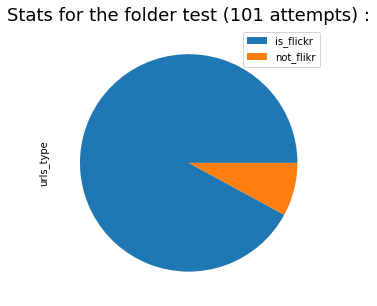

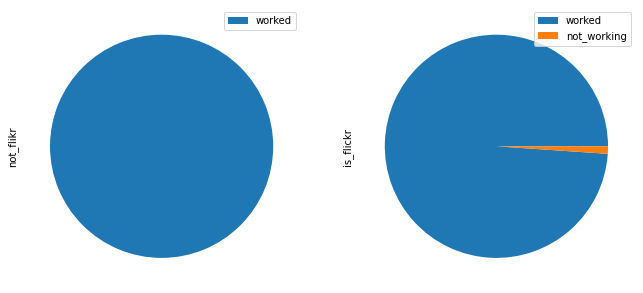

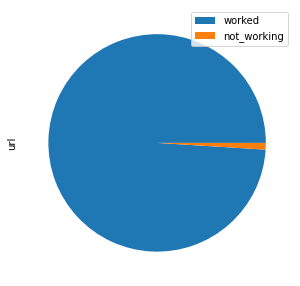

In [9]:
for folder in folders : 
    filename = f'results/{datetag}_dataset_{folder}_{HOST}.json'
    try:
        df_dataset = pd.read_json(filename)

        df_type = pd.DataFrame({'urls_type': [len(df_dataset[df_dataset['is_flickr']==1]), 
                                              len(df_dataset[df_dataset['is_flickr']==0])]},
                          index=['is_flickr', 'not_flikr'])
        df_flikr = pd.DataFrame({'not_flikr': [df_dataset[df_dataset['is_flickr']==0]['lab_work'].sum(), 
                                               (len(df_dataset[df_dataset['is_flickr']==0]) - df_dataset[df_dataset['is_flickr']==0]['lab_work'].sum())],
                                 'is_flickr': [df_dataset[df_dataset['is_flickr']==1]['lab_work'].sum(), 
                                               (len(df_dataset[df_dataset['is_flickr']==1]) - df_dataset[df_dataset['is_flickr']==1]['lab_work'].sum())]},
                                  index=['worked', 'not_working'])
        df_all = pd.DataFrame({'url': [len(df_dataset[df_dataset['lab_work']==1]), len(df_dataset[df_dataset['lab_work']==0])]},
                          index=['worked', 'not_working'])

        plot_type = df_type.plot.pie(y='urls_type', figsize=(5, 5), labeldistance=None)
        plot_type.set_title('Stats for the folder '+ folder + ' (' + str(len(df_dataset)) + ' attempts) :', size = 18)
        if not len(df_dataset[df_dataset['is_flickr']==0]) == 0 or len(df_dataset[df_dataset['is_flickr']==1]) == 0: 
            plot_flickr = df_flikr.plot.pie(subplots=True, figsize=(11, 6), labeldistance=None)
        plot_all = df_all.plot.pie(y='url', figsize=(5, 5), labeldistance=None)
    except:
        pass # TODO : make something more elegant

## Transfer learning and dataset config

In the `model.py` scrip,t we first define the `transform` functions for the datasets. To perform image augmentation, we apply the pyTorch `AutoAugment` function to the `train` and `val` dataset. Then, we load the pretrained models and store them in memory.

In [70]:
scriptname = 'DCNN_training_benchmark/model.py'

In [71]:
%%writefile {scriptname}

from DCNN_training_benchmark.init import *
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import sklearn.metrics
from scipy import stats
from scipy.special import logit, expit

# VGG-16 datasets initialisation
def datasets_transforms(image_size=args.image_size, p=0, num_workers=1, batch_size=8):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'val': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),

        'test': transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            transforms.RandomGrayscale(p=p),
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            transforms_norm ]),
    }

    image_datasets = {
        folder: datasets.ImageFolder(
            paths[folder], 
            transform=data_transforms[folder]
        )
        for folder in folders
    }

    dataloaders = {
        folder: torch.utils.data.DataLoader(
            image_datasets[folder], batch_size=batch_size,
            shuffle=True, num_workers=num_workers
        )
        for folder in folders
    }

    dataset_sizes = {folder: len(image_datasets[folder]) for folder in folders}

    return(dataset_sizes, dataloaders, image_datasets, data_transforms)

(dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size)

for folder in folders :
    print(f"Loaded {dataset_sizes[folder]} images under {folder}")
    
print("Classes: ")
class_names = image_datasets['train'].classes
print(image_datasets['train'].classes)
lay_ = len(os.listdir(paths['train']))

models = {}
opt = {}
scheduler = {}
df_train = {}

# Downloading the model
for model_name in model_names:
    model_paths[model_name] = model_path + model_name + '.pt'
    models[model_name] = torchvision.models.vgg16(pretrained=True)
    df_train[model_name] = pd.DataFrame([], columns=['epoch', 'avg_loss', 'avg_acc', 'avg_loss_val', 'avg_acc_val', 'image_size', 'device', 'model']) 

    # Freeze training for all layers
    for param in models[model_name].features.parameters():
        param.require_grad = False 
        

    # Newly created modules have require_grad=True by default
    if model_name == 'vgg16_lin':   
        num_features = models[model_name].classifier[6].out_features
        features = list(models[model_name].classifier.children())
        features.extend([nn.Linear(num_features, lay_)])
        models[model_name].classifier = nn.Sequential(*features)
        opt[model_name] = optim.SGD(models[model_name].parameters(), lr=0.001, momentum=0.9) # to set training variables
        
    else : 
        num_features = models[model_name].classifier[6].in_features
        features = list(models[model_name].classifier.children())[:-1] # Remove last layer
        features.extend([nn.Linear(num_features, lay_)]) # Add our layer with 10 outputs
        models[model_name].classifier = nn.Sequential(*features) # Replace the model classifier     
        opt[model_name] = optim.SGD(models[model_name].parameters(), lr=0.001, momentum=0.9) # to set training variables

criterion = nn.CrossEntropyLoss()       
print("Loading pretrained model..")
print("Resume_training : ", resume_training)


# Loadind a previous model
if resume_training:
    for model_name in model_paths:
        try:
            models[model_name].load_state_dict(torch.load(model_paths[model_name])) #on GPU
        except:
            models[model_name].load_state_dict(torch.load(model_paths[model_name], map_location=torch.device('cpu'))) #on CPU
            
models['vgg'] = torchvision.models.vgg16(pretrained=True)

{print("Loaded : " , model) for model in models.keys()}

Overwriting DCNN_training_benchmark/model.py


In [12]:
%run {scriptname}

Loaded 951 images under test
Loaded 980 images under val
Loaded 4952 images under train
Classes: 
['albatross', 'ant', 'bell pepper', 'computer keyboard', 'cornet', 'king penguin', 'lionfish', 'macaque', 'sewing machine', 'vending machine']
Loading pretrained model..
Resume_training :  False
Loaded :  vgg16_gray
Loaded :  vgg16_lin
Loaded :  vgg16_gen
Loaded :  vgg16_scale
Loaded :  vgg


<Figure size 432x288 with 0 Axes>

## Training process

Finaly, we implement the training process in `experiment_train.py`, using a classic training script with pyTorch. For further statistical analyses, we extract factors (like the accuracy and loss) within a `pandas` object (a `DataFrame`). 

In [72]:
scriptname = 'experiment_train.py'

In [73]:
%%writefile {scriptname}

from DCNN_training_benchmark.model import *
import copy
# LuP simplify by removing i_trials

# Training function
def train_model(model, model_name, df_train, criterion, optimizer, i_trials, num_epochs, log_interval=100):
    model.to(device)
    since = time.time()
    #best_model_wts = copy.deepcopy(model.state_dict()) # LuP : il faut m'expliquer ce point!
    #best_acc = 0.0
    
    #avg_loss = 0
    #avg_acc = 0
    #avg_loss_val = 0
    #avg_acc_val = 0
    
    # train_batches = len(dataloaders['train'])
    # val_batches = len(dataloaders['val'])
    
    
    for epoch in range(num_epochs):
        #print(f"Epoch {epoch+1}/{num_epochs}")
        #print('-' * 10)
                
        #model.train(False)
        #model.eval()
            
        with torch.no_grad():
            loss_val = 0
            acc_val = 0
            for i, (images, labels) in enumerate(dataloaders['val']):
                # if i % 100 == 0: print(f"\rValidation batch {i}/{val_batches}", end='', flush=True)

                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss_val += loss.item() * images.size(0)
                acc_val += torch.sum(preds == labels.data)

            #del images, labels, outputs, preds
            #torch.cuda.empty_cache()
            
            avg_loss_val = loss_val / dataset_sizes['val']
            avg_acc_val = acc_val / dataset_sizes['val']
            
        loss_train = 0
        acc_train = 0

        #model.train(True)
        
        for i, (images, labels) in enumerate(dataloaders['train']):
            #if i % log_interval == 0: print(f"\rTraining batch {i}/{train_batches}", end='', flush=True)
                
            # Use all the training dataset
            #if i >= train_batches : # LuP should not happen
            #    break
                
            #with torch.no_grad():
            images, labels = images.to(device), labels.to(device)   
            
            optimizer.zero_grad()

            outputs = model(images)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.item() * images.size(0)
            acc_train += torch.sum(preds == labels.data)

            #del images, labels, outputs, preds
            #torch.cuda.empty_cache()
            
        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']

        
        df_train.loc[i_trials] = {'epoch':i_trials, 'avg_loss':avg_loss, 'avg_acc':float(avg_acc),
                                  'avg_loss_val':avg_loss_val, 'avg_acc_val':float(avg_acc_val), 'image_size': image_size,
                                  'device':str(device), 'model':model_name}
        i_trials +=1
        #print()
        #print('-' * 10)
        print(f"Epoch {epoch+1}/{num_epochs} : train= loss: {avg_loss:.4f} / acc : {avg_acc:.4f} - val= loss : {avg_loss_val:.4f} / acc : {avg_acc_val:.4f}")
        #print('-' * 10)
        #print()
        
        #if avg_acc_val > best_acc:
        #    best_acc = avg_acc_val
        #    best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    print()
    #print(f"Best acc: {best_acc:.4f}")
    
    #model.load_state_dict(best_model_wts)
    model.cpu()
    return (model, df_train, i_trials)

# Training and saving the network
print( f'Train scale : {train_scale}, Train gray : {train_gray}, Train basic : {train_base}')    
for model_name in models.keys():
    filename = f'results/{datetag}_{HOST}_train_{model_name}.json'
    i_trials = 0
    p = 1 if model_name == 'vgg16_gray' else 0
    print(f"Traning {model_name}, image_size = {image_size}, p (Grayscale) = {p}, i_trials = {i_trials}")
    if model_name == 'vgg16_gray':
        if train_gray :            
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, p=p)
            models[model_name], df_train[model_name], i_trials = train_model(models[model_name], model_name, df_train[model_name], criterion=criterion, optimizer=opt[model_name], i_trials=i_trials, num_epochs=num_epochs)
            torch.save(models[model_name].state_dict(), model_paths[model_name])
            torch.cuda.empty_cache()
        df_train[model_name].to_json(filename)

    elif model_name =='vgg16_scale':
        if train_scale :
            for image_size in image_sizes: # starting with low resolution images 
                (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, p=p)
                models[model_name], df_train[model_name], i_trials = train_model(models[model_name], model_name, df_train[model_name], criterion, optimizer=opt[model_name], i_trials=i_trials, num_epochs=num_epochs) # need more epochs per scale
                torch.save(models[model_name].state_dict(), model_paths[model_name])
                torch.cuda.empty_cache()
            image_size = args.image_size
            df_train[model_name].to_json(filename)
    else :
        if train_base :
            (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size, p=p)
            models[model_name], df_train[model_name], i_trials = train_model(models[model_name], model_name, df_train[model_name], criterion, optimizer=opt[model_name], i_trials=i_trials, num_epochs=num_epochs)
            torch.cuda.empty_cache()
            torch.save(models[model_name].state_dict(), model_paths[model_name])
            df_train[model_name].to_json(filename)

Overwriting experiment_train.py


In [15]:
%run {scriptname}

Loaded 951 images under test
Loaded 980 images under val
Loaded 4952 images under train
Classes: 
['albatross', 'ant', 'bell pepper', 'computer keyboard', 'cornet', 'king penguin', 'lionfish', 'macaque', 'sewing machine', 'vending machine']
Loading pretrained model..
Resume_training :  False
Loaded :  vgg16_gray
Loaded :  vgg16_lin
Loaded :  vgg16_gen
Loaded :  vgg16_scale
Loaded :  vgg
Train scale : True, Train gray : True, Train basic : True
Traning vgg16_gray, image_size = 256, p (Grayscale) = 1, i_trials = 0


/home/laurent/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/5 : train= loss: 0.5438 / acc : 0.8288 - val= loss : 0.3698 / acc : 0.8837
Epoch 2/5 : train= loss: 0.3298 / acc : 0.8956 - val= loss : 0.1845 / acc : 0.9490
Epoch 3/5 : train= loss: 0.2268 / acc : 0.9299 - val= loss : 0.3124 / acc : 0.9061
Epoch 4/5 : train= loss: 0.1821 / acc : 0.9437 - val= loss : 0.1904 / acc : 0.9408
Epoch 5/5 : train= loss: 0.1432 / acc : 0.9513 - val= loss : 0.2702 / acc : 0.9286

Training completed in 5m 13s
Best acc: 0.9490
Traning vgg16_lin, image_size = 256, p (Grayscale) = 0, i_trials = 0
Epoch 1/5 : train= loss: 0.5021 / acc : 0.8459 - val= loss : 0.3291 / acc : 0.8959
Epoch 2/5 : train= loss: 0.2805 / acc : 0.9150 - val= loss : 0.2952 / acc : 0.9000
Epoch 3/5 : train= loss: 0.1911 / acc : 0.9358 - val= loss : 0.1974 / acc : 0.9500
Epoch 4/5 : train= loss: 0.1661 / acc : 0.9451 - val= loss : 0.2038 / acc : 0.9398
Epoch 5/5 : train= loss: 0.1526 / acc : 0.9493 - val= loss : 0.1505 / acc : 0.9520

Training completed in 5m 12s
Best acc: 0.9520
Traning

KeyError: 'vgg'

Here we display both average accuracy and loss during the training phase and during the validation one : 

ValueError: Expected object or value

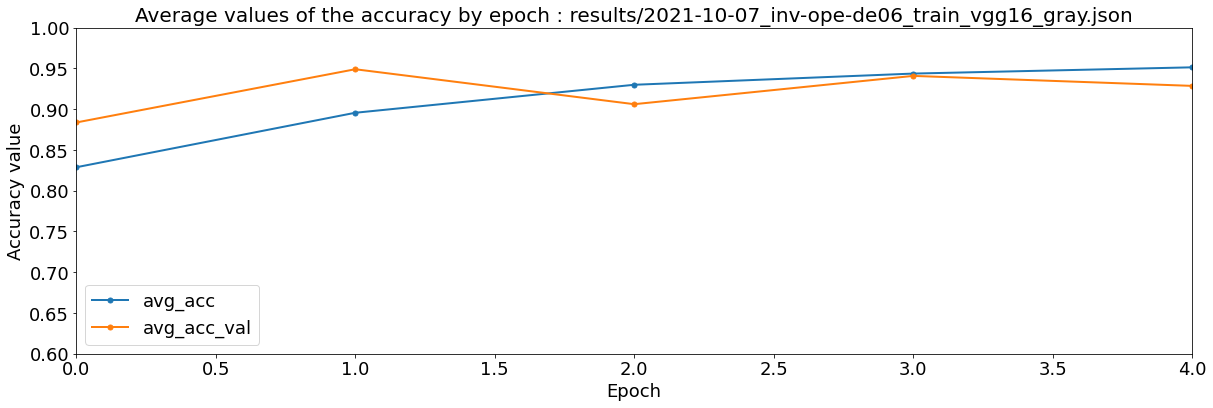

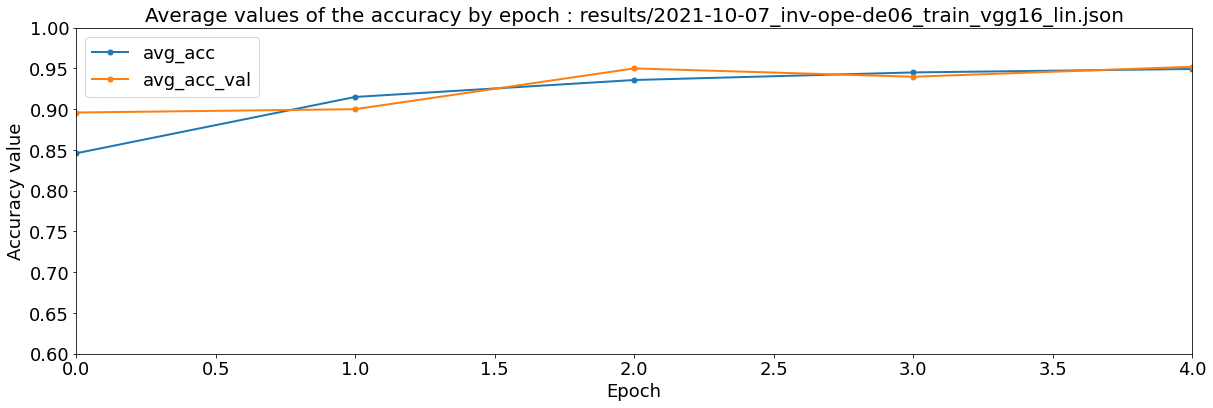

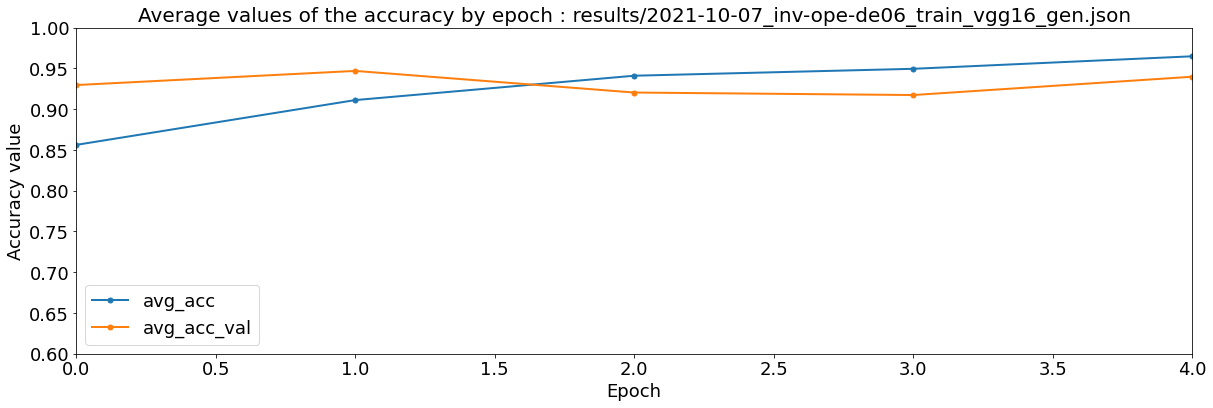

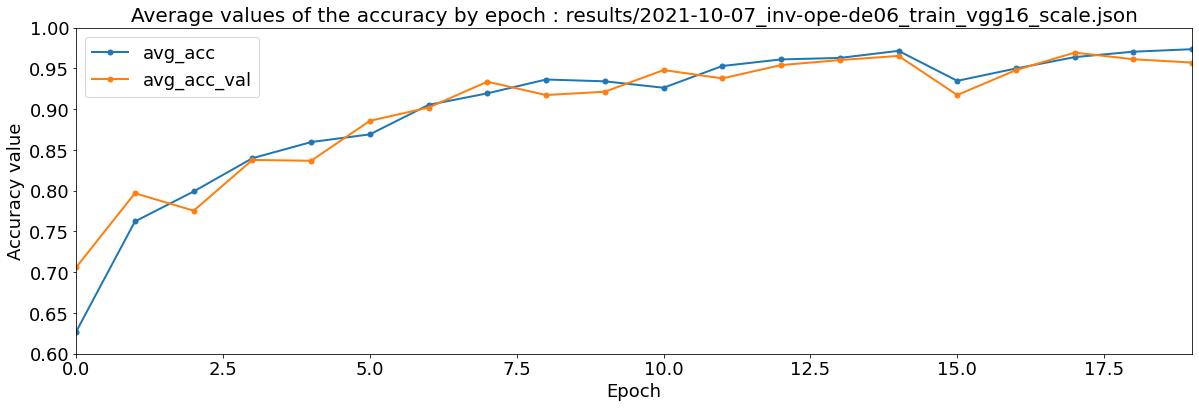

In [16]:
for model_name in models.keys():
    filename = f'results/{datetag}_{HOST}_train_{model_name}.json'
    #filename = f'results/2021-04-19_INV-133-DE01_train_{name}.json'
    #filename = f'results/2021-03-02_train_INV-133-DE01.json'
    df_train = pd.read_json(filename)
    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi//2))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax = df_train['avg_acc'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_acc_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_acc", "avg_acc_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Accuracy value", size=18)
    ax.set_ylim(0.60, 1)
    axs.set_title(f'Average values of the accuracy by epoch : {filename}' , size = 20)

ValueError: Expected object or value

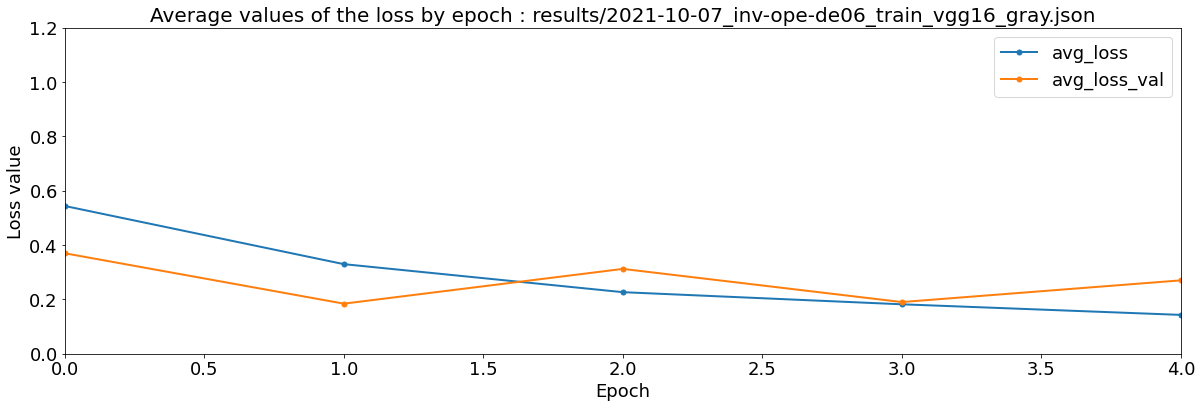

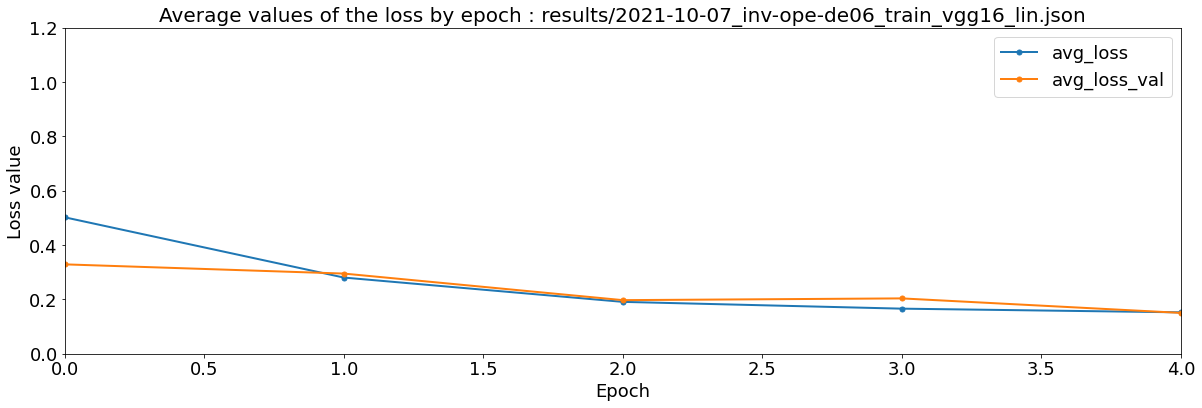

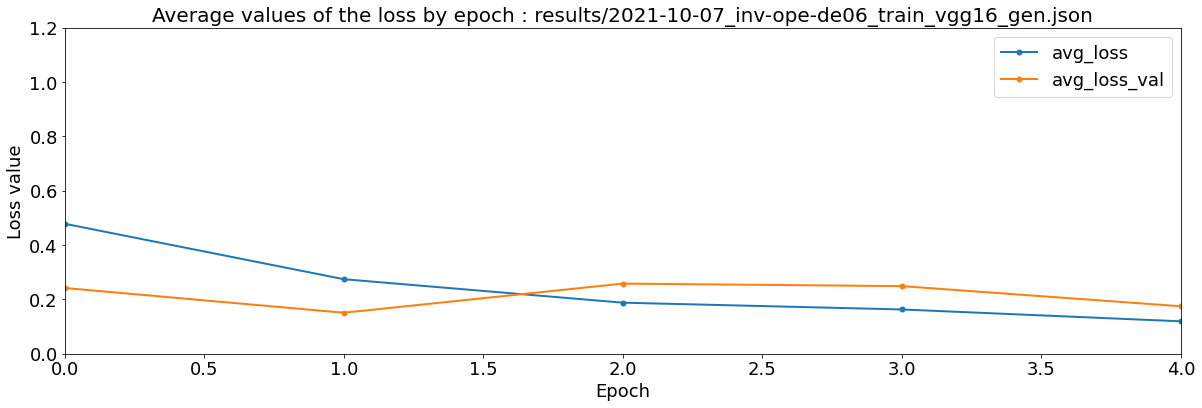

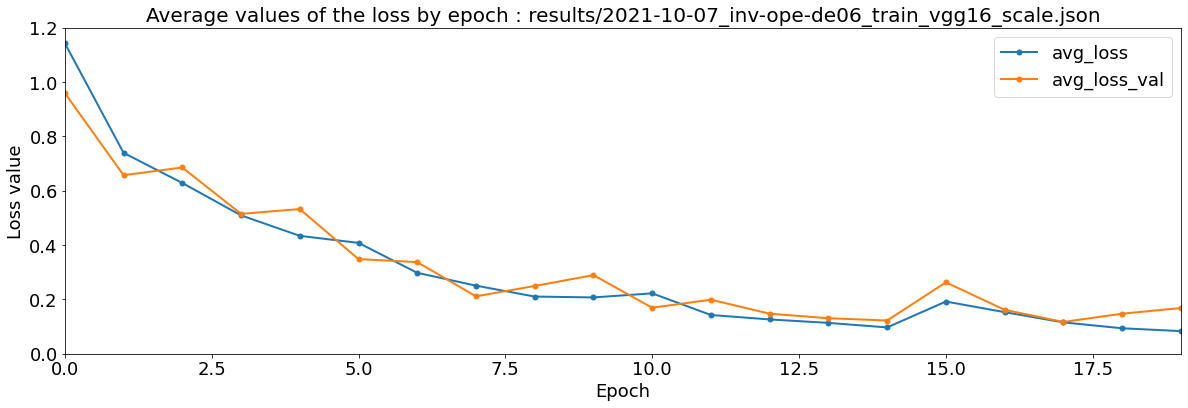

In [17]:
for model_name in models.keys():
    filename = f'results/{datetag}_{HOST}_train_{model_name}.json'
    #filename = f'results/2021-04-19_INV-133-DE01_train_{name}.json'
    df_train = pd.read_json(filename)

    fig, axs = plt.subplots(figsize=(fig_width, fig_width/phi//2))
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    ax = df_train['avg_loss'].plot(lw=2, marker='.', markersize=10)
    ax = df_train['avg_loss_val'].plot(lw=2, marker='.', markersize=10)
    ax.legend(["avg_loss", "avg_loss_val"], fontsize=18);
    ax.set_xlabel("Epoch", size=18)
    ax.set_ylabel("Loss value", size=18)
    ax.set_ylim(0, 1.2)
    axs.set_title(f'Average values of the loss by epoch : {filename}' , size = 20)

# Experiment 1: Image processing and recognition for differents labels 


The networks are now ready for a quantitative evaluation. The second part of this notebook offers a comparison between : 

- A pre-trained image recognition's networks, here VGG, trained on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for $1000$ labels, taken from the `torchvision.models` library

- And four re-trained version of the same network VGG16 based on a reduced Imagenet dataset wich allows to focus on naturals images from $10$ labels.

For further statistical analyses, we extract these differents factors (like the accuracy and the processing time for differents datasets at differents resolution) in a `pandas` object. 

In [74]:
scriptname = 'experiment_basic.py'

In [75]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_training_benchmark.model import *

filename = f'results/{datetag}_results_1_{HOST}.json'

try:
    df = pd.read_json(filename)
except:
    df = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device', 'top_1']) 
    i_trial = 0
    for i_image, (data, label) in enumerate(image_datasets['test']):
        for model_name in models.keys():
            model = models[model_name].to(device)
            with torch.no_grad():
                i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                if model_name == 'vgg' : # our previous work
                    percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                    _, indices = torch.sort(out, descending=True)
                    top_1 = labels[indices[0]]
                    perf_ = percentage[reverse_i_labels[i_label_top]].item()
                else :
                    percentage = torch.nn.functional.softmax(out, dim=0) * 100
                    _, indices = torch.sort(out, descending=True)
                    top_1 = reverse_model_labels[indices[0]] 
                    perf_ = percentage[label].item()
            elapsed_time = time.time() - tic            
            df.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':elapsed_time, 'fps': 1/elapsed_time,
                               'label':labels[i_label_top], 'i_label':i_label_top, 
                               'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'device':str(device), 'top_1':top_1}
            print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {elapsed_time:.3f} seconds, best confidence for : {top_1}')
            i_trial += 1
    df.to_json(filename)

Overwriting experiment_basic.py


In [ ]:
%run {scriptname}

Here we collect our results, we can already display all the data in a table 

In [21]:
filename = f'results/{datetag}_results_1_{HOST}.json'
#filename = 'results/2021-04-20_results_1_INV-133-DE01.json'
df = pd.read_json(filename)
df

model        perf         fps      time            label  i_label  \
0      vgg16_gray   68.652245  195.547764  0.005114        albatross      146   
1       vgg16_lin   99.999832  205.643460  0.004863        albatross      146   
2       vgg16_gen   88.335320  232.332798  0.004304        albatross      146   
3     vgg16_scale  100.000000  233.457865  0.004283        albatross      146   
4             vgg   99.999985  132.924637  0.007523        albatross      146   
...           ...         ...         ...       ...              ...      ...   
4750   vgg16_gray    0.000889  203.212403  0.004921  vending machine      886   
4751    vgg16_lin    0.006955  197.872529  0.005054  vending machine      886   
4752    vgg16_gen    0.470697  206.727981  0.004837  vending machine      886   
4753  vgg16_scale    1.020766  206.432917  0.004844  vending machine      886   
4754          vgg   99.982086  199.957285  0.005001  vending machine      886   

      i_image                                           filename  \
0           0                     data/test/albatross/0712-2.jpg   
1           0                     data/test/albatross/0712-2.jpg   
2           0                     data/test/albatross/0712-2.jpg   
3           0                     data/test/albatross/0712-2.jpg   
4           0                     data/test/albatross/0712-2.jpg   
...       ...                                                ...   
4750      950  data/test/vending machine/wine-vending-machine...   
4751      950  data/test/vending machine/wine-vending-machine...   
4752      950  data/test/vending machine/wine-vending-machine...   
4753      950  data/test/vending machine/wine-vending-machine...   
4754      950  data/test/vending machine/wine-vending-machine...   

            device            top_1  
0     {'index': 0}        albatross  
1     {'index': 0}        albatross  
2     {'index': 0}        albatross  
3     {'index': 0}        albatross  
4     {'index': 0}        albatross  
...            ...              ...  
4750  {'index': 0}  vending machine  
4751  {'index': 0}  vending machine  
4752  {'index': 0}  vending machine  
4753  {'index': 0}  vending machine  
4754  {'index': 0}  vending machine  

[4755 rows x 10 columns]

## Accuracy, Precision, Recall

Here we are displaying the acuracy top 1 (wich is a metric that generally describes how the model performs across all classes, here top 1 because we only take the best likelihood at the exit of the networks), the precision (which reflects how reliable the model is in classifying samples as Positive) and the recall (which measures the model's ability to detect Positive samples) of each networks. We decided to use the [sklearn librairy](https://sklearn.org/index.html) to perform this [analysis](https://blog.paperspace.com/deep-learning-metrics-precision-recall-accuracy/)

In [25]:
reverse_model_labels

['albatross',
 'ant',
 'bell pepper',
 'computer keyboard',
 'cornet',
 'king penguin',
 'lionfish',
 'macaque',
 'sewing machine',
 'vending machine']

In [26]:
recall = sklearn.metrics.recall_score(ground_true, model_pred, average = None, zero_division = 0)
print(recall)

[0.         0.         0.         0.9375     0.         0.
 0.         0.93939394 0.         0.         0.64035088 0.
 0.         0.872      0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.95145631 0.
 0.         0.         0.         0.95       0.80373832 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.89361702 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.84536082 0.         0.         0.
 0.         0.        ]


In [27]:
results = {} 
results['acc'] = []
results['precision'] = {}
results['recall'] = {}

for model_name in models.keys() :
    model_pred = df[df['model']==model_name]["top_1"].values.tolist()
    ground_true = df[df['model']==model_name]["label"].values.tolist()
    acc = sklearn.metrics.accuracy_score(ground_true, model_pred)
    results['acc'].append(acc)
    pres = multilabel_confusion_matrix(ground_true, model_pred)
    results['precision'][model_name] = []
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[-1][0]))
        print('precision : ' , pres_)
        results['precision'][model_name].append(pres_)
    results['recall'][model_name] = []
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = (pres_[0][0]) / (pres_[0][0] + pres_[0][-1])
        print('recall : ' , pres_)
        results['recall'][model_name].append(pres_)

for mode in ['recall', 'precision']:
    df_acc = pd.DataFrame({'vgg16_gray': results[mode]['vgg16_gray'],
                           'vgg16_lin': results[mode]['vgg16_lin'],
                           'vgg16_gen': results[mode]['vgg16_gen'],
                           'vgg16_scale': results[mode]['vgg16_scale'],
                           'vgg': results[mode]['vgg']}, index=reverse_model_labels)
    ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
    ax.set_title(mode.capitalize()+' for each models on the first experiments : ', size=20)
    ax.set_ylabel(mode.capitalize(), size= 16)
    ax.set_xlabel('Labels', size= 14)

df_acc = pd.DataFrame({'accuracy': results['acc']},
                  index = models.keys())

ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 18)
ax.set_title('Accuracy top_1 : for each models on the first experiments : ', size=20)
ax.set_ylabel('Probability', size= 14)
ax.set_xlabel('Models', size= 14)

precision :  0.972972972972973
precision :  0.9611650485436893
precision :  0.9819819819819819
precision :  0.9669421487603306
precision :  1.0
precision :  1.0
precision :  0.9814814814814815
precision :  0.9393939393939394
precision :  0.96
recall :  0.9642857142857143
recall :  1.0
recall :  0.956140350877193
recall :  0.936
recall :  0.970873786407767
recall :  0.98
recall :  0.9906542056074766
recall :  0.9893617021276596
recall :  0.9896907216494846
precision :  0.9316239316239316
precision :  0.0
precision :  1.0
precision :  0.9826086956521739
precision :  0.96
precision :  1.0
precision :  0.970873786407767
precision :  0.9904761904761905
precision :  0.9574468085106383
precision :  0.9795918367346939
recall :  0.9732142857142857
recall :  nan
recall :  0.98989898989899
recall :  0.9912280701754386
recall :  0.96
recall :  0.9223300970873787
recall :  1.0
recall :  0.9719626168224299
recall :  0.9574468085106383
recall :  0.9896907216494846
precision :  1.0
precision :  0.0
pr

<ipython-input-27-0d97f5d6278f>:21: RuntimeWarning: invalid value encountered in long_scalars
  pres_ = (pres_[0][0]) / (pres_[0][0] + pres_[0][-1])


ValueError: Shape of passed values is (9, 5), indices imply (10, 5)

In [28]:
model_pred = df[df['model']=='vgg']["top_1"].values.tolist()
ground_true = df[df['model']=='vgg']["label"].values.tolist()
acc = sklearn.metrics.accuracy_score(ground_true, model_pred)
#results['acc'].append(acc)
pres = multilabel_confusion_matrix(ground_true, model_pred)

## Computation time

A display of the differents computation time of each models on the same dataset for the sequence of trials :

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning

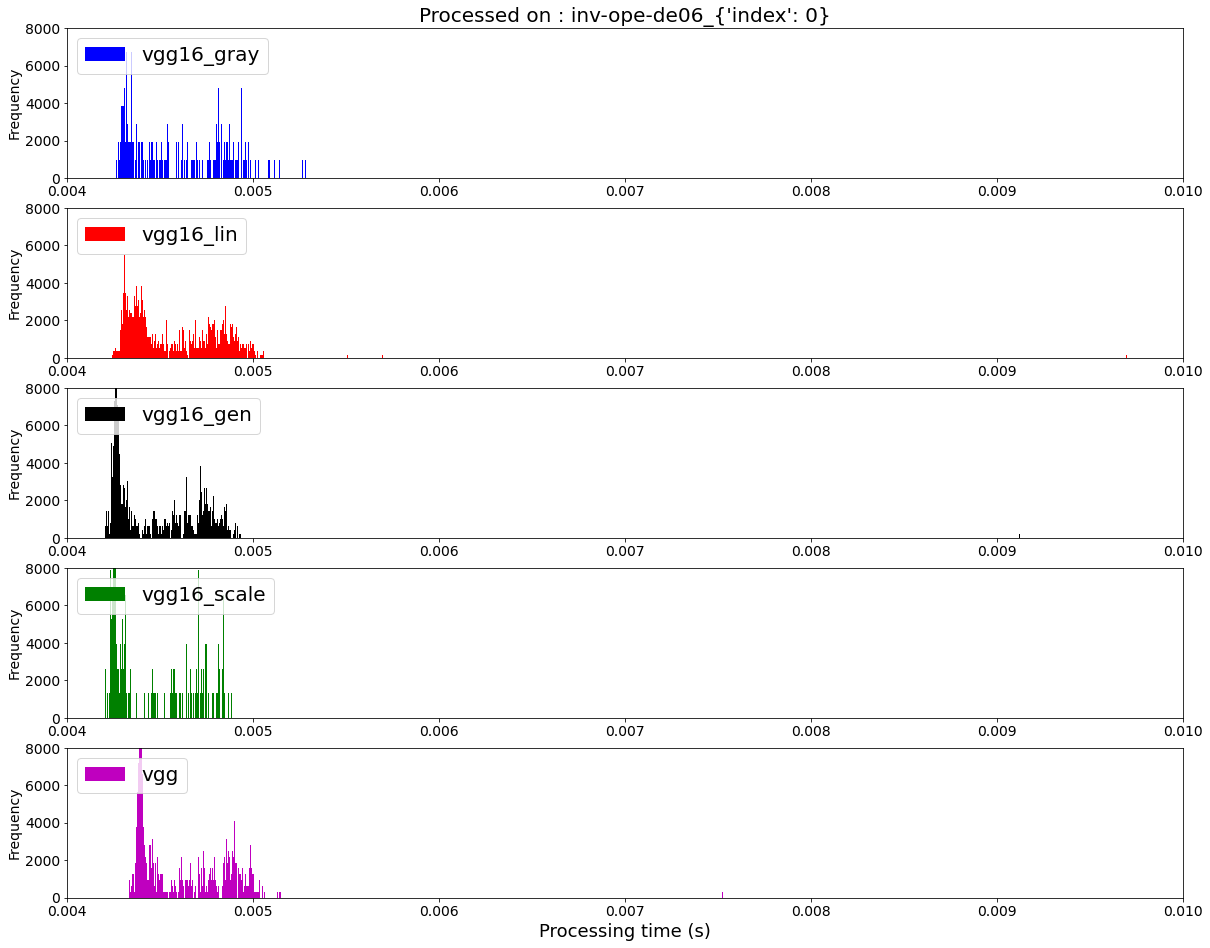

In [29]:
fig, axs = plt.subplots(len(models.keys()), 1, figsize=(fig_width, fig_width*phi//2))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df[df['model']==model_name]['time'].plot.hist(bins=len(df[df['model']==model_name]['time']), lw=1, label=model_name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize = 20)
    ax.set_xlim(0.004, 0.01)
    ax.set_ylim(0, 8000)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Processing time (s)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + df['device'][0], size = 20);

## Classification likelihood

This graph shows the frequency of the logit of the classification likelihood for our four models and the pyTorch VGG16 model. The classification likelihood represent a probability of detection for a given label at the output of the network. As most of them are close either to 100 as to 0, we applied a logit function to make the difference between these networks more obvious.    

TODO voir si on peut donner la valeur du logit en hartley base 10 https://en.wikipedia.org/wiki/Hartley_(unit)  tracer le chance level

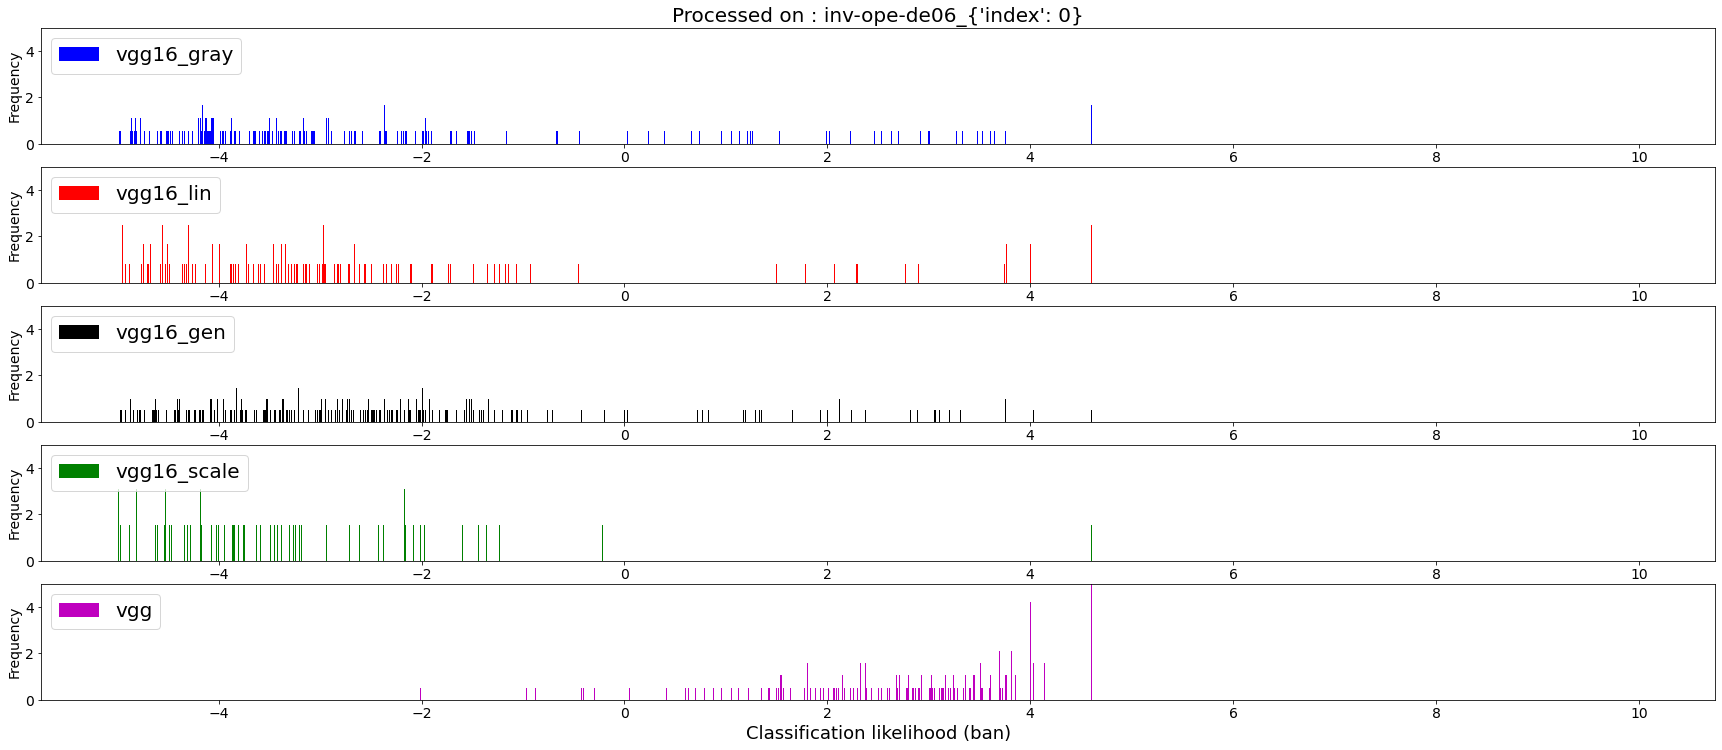

In [30]:
fig, axs = plt.subplots(len(models.keys()), 1, figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    (logit(df[df['model']==model_name]['perf']/100)/np.log2(10)).plot.hist(bins=np.linspace(-5, 10, len(df['perf'])), lw=1, label=model_name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize = 20)
    ax.set_ylim(0, 5)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification likelihood (ban)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + df['device'][0], size = 20);

## Image display

Here we display the 64 *worsts* Classification likelihood's, all model combined : 

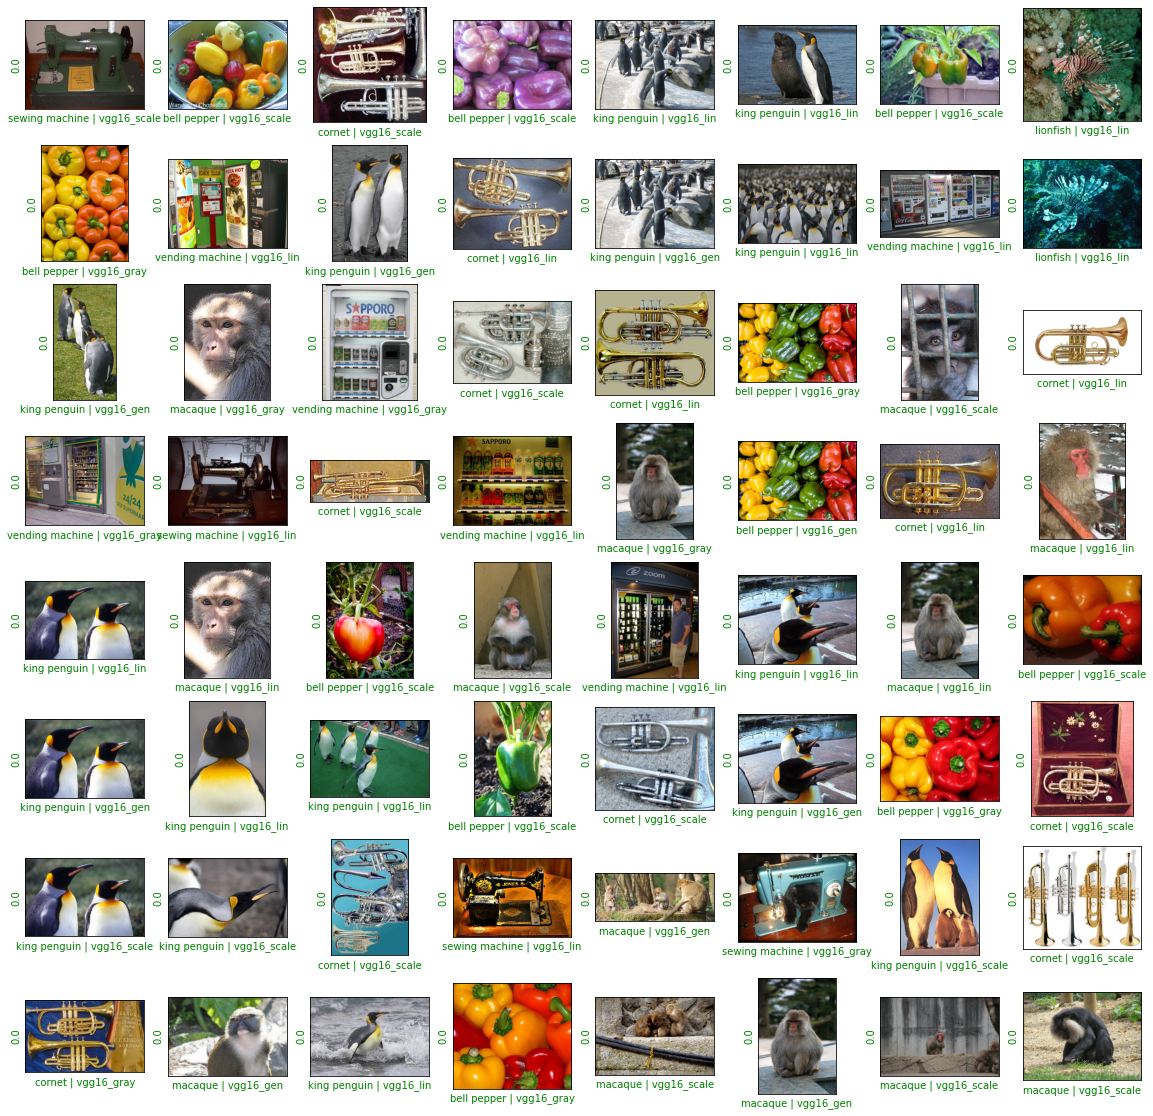

In [31]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(fig_width, fig_width))
for i, idx in enumerate(df["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df.loc[idx]['label'] + ' | ' + df.loc[idx]['model'], color='g')
    perf_ = df.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

## Means

To make it even clearer we extracted a specific mean for each models : 

Classification likelihood's mean

In [32]:
for model_name in models.keys():
    med_perf = np.mean(df[df['model']==model_name]["perf"])
    print(f'For the {model_name} model, the mean clasification likelihood =  {med_perf:.4f} %' )

For the vgg16_gray model, the mean clasification likelihood =  11.4940 %
For the vgg16_lin model, the mean clasification likelihood =  11.8494 %
For the vgg16_gen model, the mean clasification likelihood =  11.3002 %
For the vgg16_scale model, the mean clasification likelihood =  11.9458 %
For the vgg model, the mean clasification likelihood =  98.4882 %


Computation time 's mean

In [33]:
for model_name in models.keys():
    med_perf = np.mean(df[df['model']==model_name]["time"])
    print(f'For the {model_name} model, the mean computation time  =  {med_perf:.5f} s')

For the vgg16_gray model, the mean computation time  =  0.00457 s
For the vgg16_lin model, the mean computation time  =  0.00458 s
For the vgg16_gen model, the mean computation time  =  0.00448 s
For the vgg16_scale model, the mean computation time  =  0.00447 s
For the vgg model, the mean computation time  =  0.00462 s


Frame per second's mean

In [34]:
for model_name in models.keys():
    med_perf = np.mean(df[df['model']==model_name]["fps"])
    print(f'For the {model_name} model, the mean fps  =  {med_perf:.3f} Hz' )

For the vgg16_gray model, the mean fps  =  219.225 Hz
For the vgg16_lin model, the mean fps  =  219.114 Hz
For the vgg16_gen model, the mean fps  =  223.691 Hz
For the vgg16_scale model, the mean fps  =  224.364 Hz
For the vgg model, the mean fps  =  216.853 Hz


# Experiment 2: Image processing and recognition for differents resolutions :

Let's now study that same likelihood indicators at different image resolutions.

In [76]:
scriptname = 'experiment_downsample.py'

In [77]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_training_benchmark.model import *
filename = f'results/{datetag}_results_2_{HOST}.json'

# Output's set up
try:
    df_downsample = pd.read_json(filename)
except:
    df_downsample = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'image_size', 'filename', 'device', 'top_1']) 
    i_trial = 0

    # image preprocessing
    for image_size in image_sizes:
        (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(image_size=image_size)
        print(f'Résolution de {image_size=}')
        
        # Displays the input image of the model 
        for i_image, (data, label) in enumerate(image_datasets['test']):
            for model_name in models.keys():
                model = models[model_name]
                model.eval()
                i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                if model_name == 'vgg' :
                    percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                    _, indices = torch.sort(out, descending=True)
                    top_1 = labels[indices[0]]
                    perf_ = percentage[reverse_i_labels[i_label_top]].item()
                else :
                    percentage = torch.nn.functional.softmax(out, dim=0) * 100
                    _, indices = torch.sort(out, descending=True)
                    top_1 = reverse_model_labels[indices[0]] 
                    perf_ = percentage[label].item()     
                dt = time.time() - tic           
                df_downsample.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'image_size': image_size, 'device':str(device), 'top_1':str(top_1)}
                print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds, best confidence for : {top_1}')
                i_trial += 1
        df_downsample.to_json(filename)

Overwriting experiment_downsample.py


In [ ]:
%run {scriptname}

Here, again, we collect our results, and display all the data in a table 

In [38]:
filename = f'results/{datetag}_results_2_{HOST}.json'
#filename = 'results/2021-04-20_results_2_INV-133-DE01.json'
df_downsample = pd.read_json(filename)
df_downsample

model        perf         fps      time            label  \
0       vgg16_gray    1.417812   60.405323  0.016555        albatross   
1        vgg16_lin  100.000000  253.984740  0.003937        albatross   
2        vgg16_gen    0.559744  324.636533  0.003080        albatross   
3      vgg16_scale  100.000000  326.684633  0.003061        albatross   
4              vgg   99.999931  303.583092  0.003294        albatross   
...            ...         ...         ...       ...              ...   
19015   vgg16_gray    0.082374   79.311399  0.012609  vending machine   
19016    vgg16_lin    0.371395   77.987133  0.012823  vending machine   
19017    vgg16_gen    2.480534   77.972635  0.012825  vending machine   
19018  vgg16_scale    1.604164   78.448060  0.012747  vending machine   
19019          vgg   98.368881   76.777975  0.013025  vending machine   

       i_label  i_image  image_size  \
0          146        0          64   
1          146        0          64   
2          146        0          64   
3          146        0          64   
4          146        0          64   
...        ...      ...         ...   
19015      886      950         512   
19016      886      950         512   
19017      886      950         512   
19018      886      950         512   
19019      886      950         512   

                                                filename        device  \
0                         data/test/albatross/0712-2.jpg  {'index': 0}   
1                         data/test/albatross/0712-2.jpg  {'index': 0}   
2                         data/test/albatross/0712-2.jpg  {'index': 0}   
3                         data/test/albatross/0712-2.jpg  {'index': 0}   
4                         data/test/albatross/0712-2.jpg  {'index': 0}   
...                                                  ...           ...   
19015  data/test/vending machine/wine-vending-machine...  {'index': 0}   
19016  data/test/vending machine/wine-vending-machine...  {'index': 0}   
19017  data/test/vending machine/wine-vending-machine...  {'index': 0}   
19018  data/test/vending machine/wine-vending-machine...  {'index': 0}   
19019  data/test/vending machine/wine-vending-machine...  {'index': 0}   

                 top_1  
0         king penguin  
1            albatross  
2         king penguin  
3            albatross  
4            albatross  
...                ...  
19015  vending machine  
19016  vending machine  
19017  vending machine  
19018  vending machine  
19019   medicine chest  

[19020 rows x 11 columns]

## Accuracy, Precision, Recall

And extract the accuracy, the precision ans the recall for each networks :

<ipython-input-39-64ae0633c638>:25: RuntimeWarning: invalid value encountered in long_scalars
  pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))


ValueError: Shape of passed values is (9, 5), indices imply (10, 5)

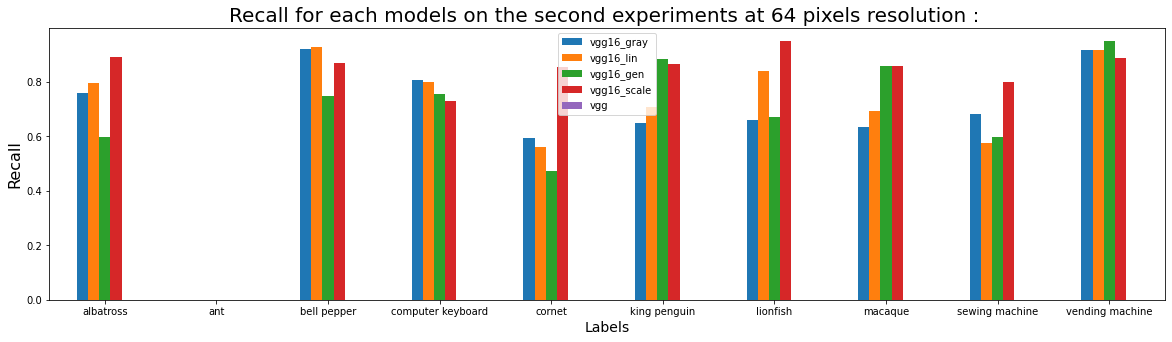

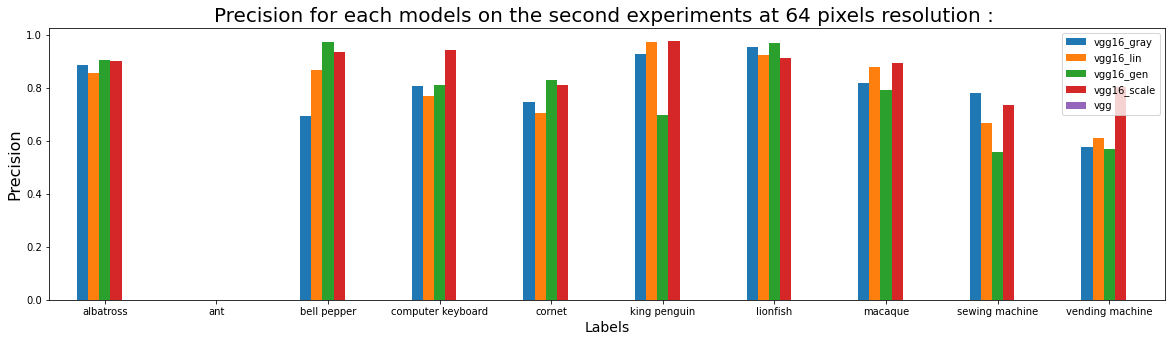

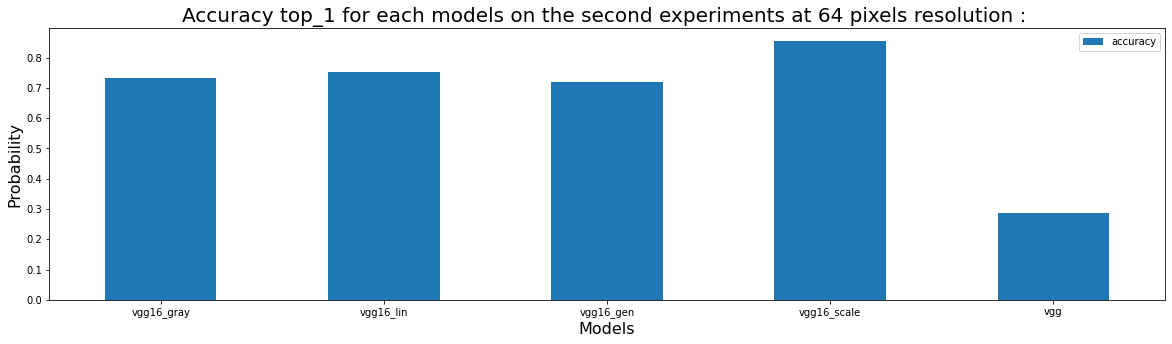

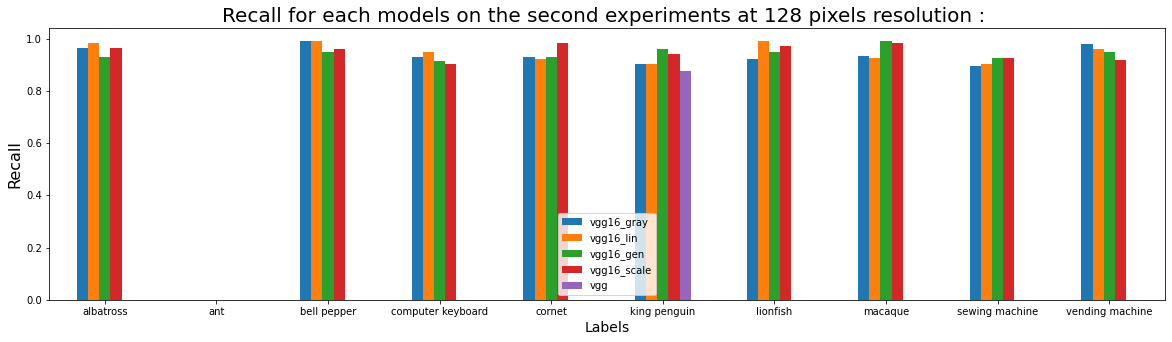

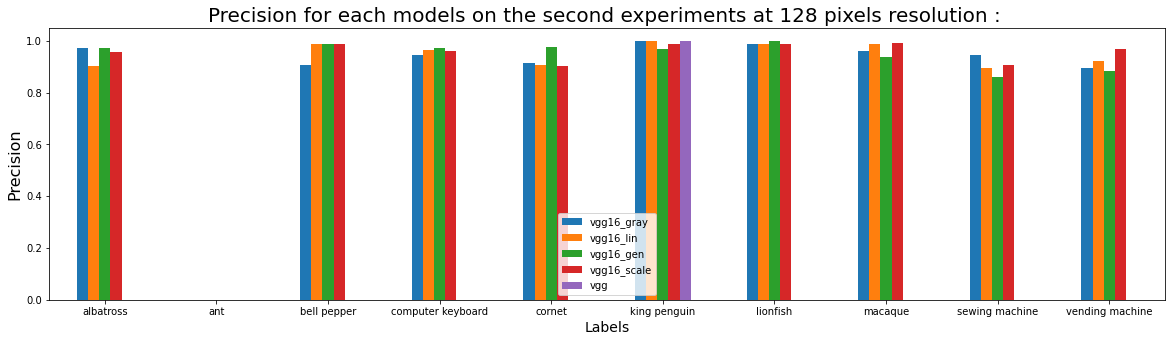

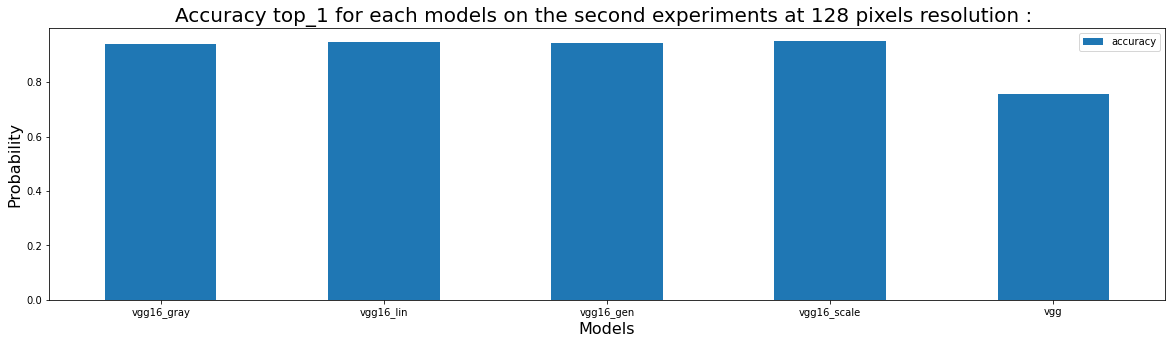

In [39]:
results = {} 
for image_size in image_sizes:
    results[str(image_size)] = {}
    results[str(image_size)]['acc'] = []
    results[str(image_size)]['precision'] = {}
    results[str(image_size)]['recall'] = {}
    for model_name in models.keys() :
        model_pred = df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["top_1"]
        ground_true = df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["label"]
        acc = sklearn.metrics.accuracy_score(ground_true, model_pred)
        results[str(image_size)]['acc'].append(acc)
        #print(f'Accuracy top_1 : {acc:.3f}')
        pres = multilabel_confusion_matrix(ground_true, model_pred)
        results[str(image_size)]['precision'][model_name] = []
        #pprint('Precision :')
        for i, label in zip(pres, reverse_model_labels) :
            pres_ = np.flip(i)
            pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[-1][0]))
            results[str(image_size)]['precision'][model_name].append(pres_)
            #print(f'{pres_:.3f} for the label {label}')
        results[str(image_size)]['recall'][model_name] = []
        #pprint('Recall :')
        for i, label in zip(pres, reverse_model_labels) :
            pres_ = np.flip(i)
            pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))
            results[str(image_size)]['recall'][model_name].append(pres_)
            #print(f'{pres_:.3f} for the label {label}')

    for mode in ['recall', 'precision']:
        df_acc = pd.DataFrame({'vgg16_gray': results[str(image_size)][mode]['vgg16_gray'],
                            'vgg16_lin': results[str(image_size)][mode]['vgg16_lin'],
                             'vgg16_gen': results[str(image_size)][mode]['vgg16_gen'],
                              'vgg16_scale': results[str(image_size)][mode]['vgg16_scale'],
                               'vgg': results[str(image_size)][mode]['vgg'],
                          }, index=reverse_model_labels)
        ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
        ax.set_title(mode.capitalize()+' for each models on the second experiments at ' + str(image_size) + ' pixels resolution : ', size=20)
        ax.set_ylabel(mode.capitalize(), size= 16)
        ax.set_xlabel('Labels', size= 14)
    df_acc = pd.DataFrame({'accuracy': results[str(image_size)]['acc']},
                      index = models.keys())
    ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
    ax.set_title(str('Accuracy top_1 for each models on the second experiments at ' + str(image_size) + ' pixels resolution : ') , size=20)
    ax.set_ylabel('Probability', size= 16)
    ax.set_xlabel('Models', size= 16)

## Computation time

A display of the differents computation time of each models on the same dataset for differents resolutions :

TypeError: can only concatenate str (not "dict") to str

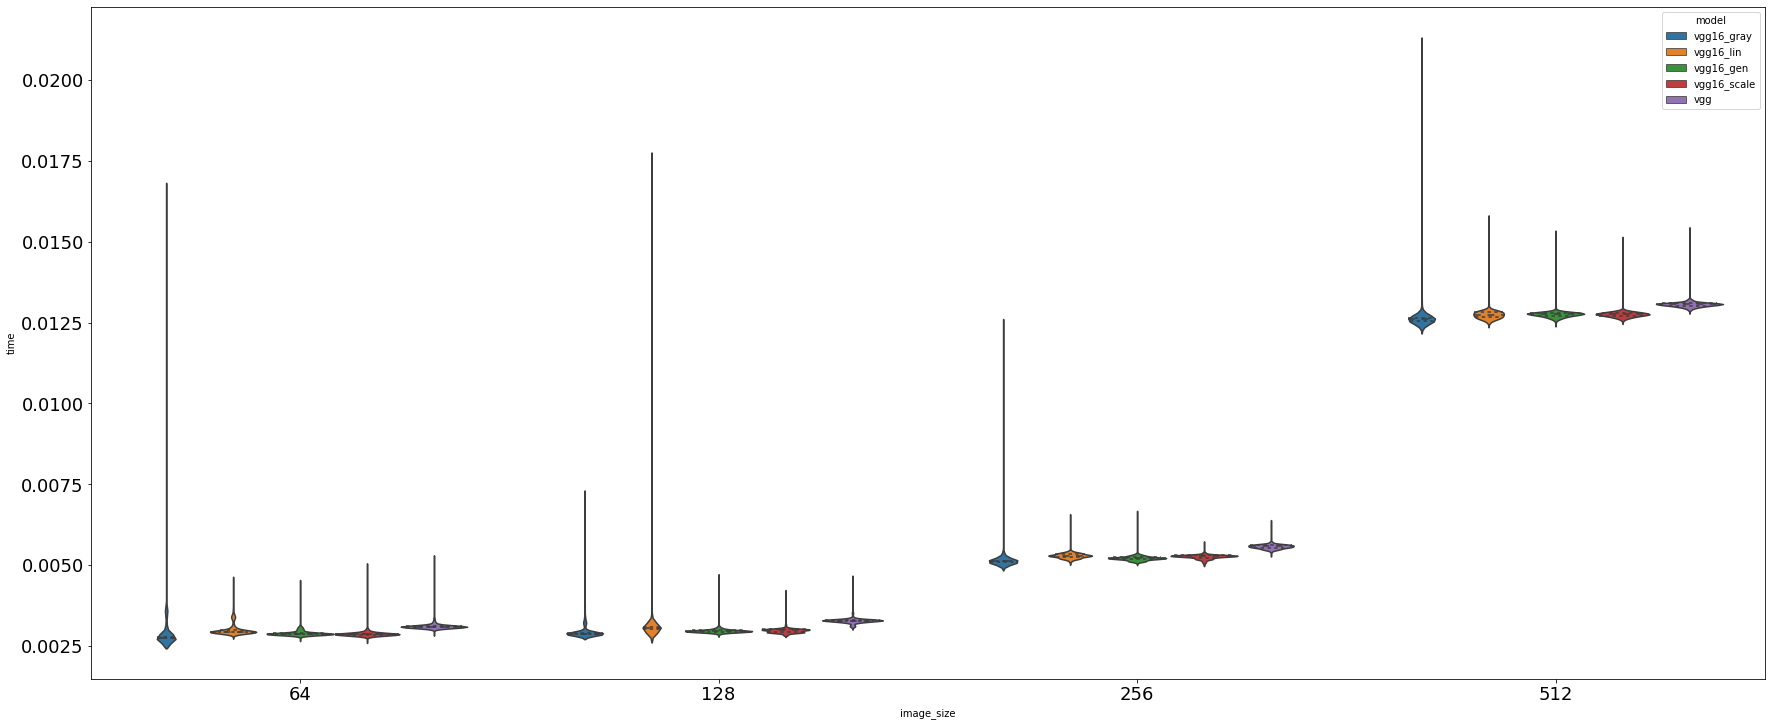

In [40]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, model_name in zip(colors, models.keys()):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample, inner="quartile", hue='model')
    axs.set_title('Processed on : ' + HOST + '_' + str(df_downsample['device'][0]), size = 20)
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    axs.set_yscale('log')
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc='upper center', fontsize=16);    

## Classification likelihood

Let's display the likelihood of each models on the same dataset for differents resolutions. Here accuracies are displayed as a violin plot to allow a better representation of the models.

TypeError: can only concatenate str (not "dict") to str

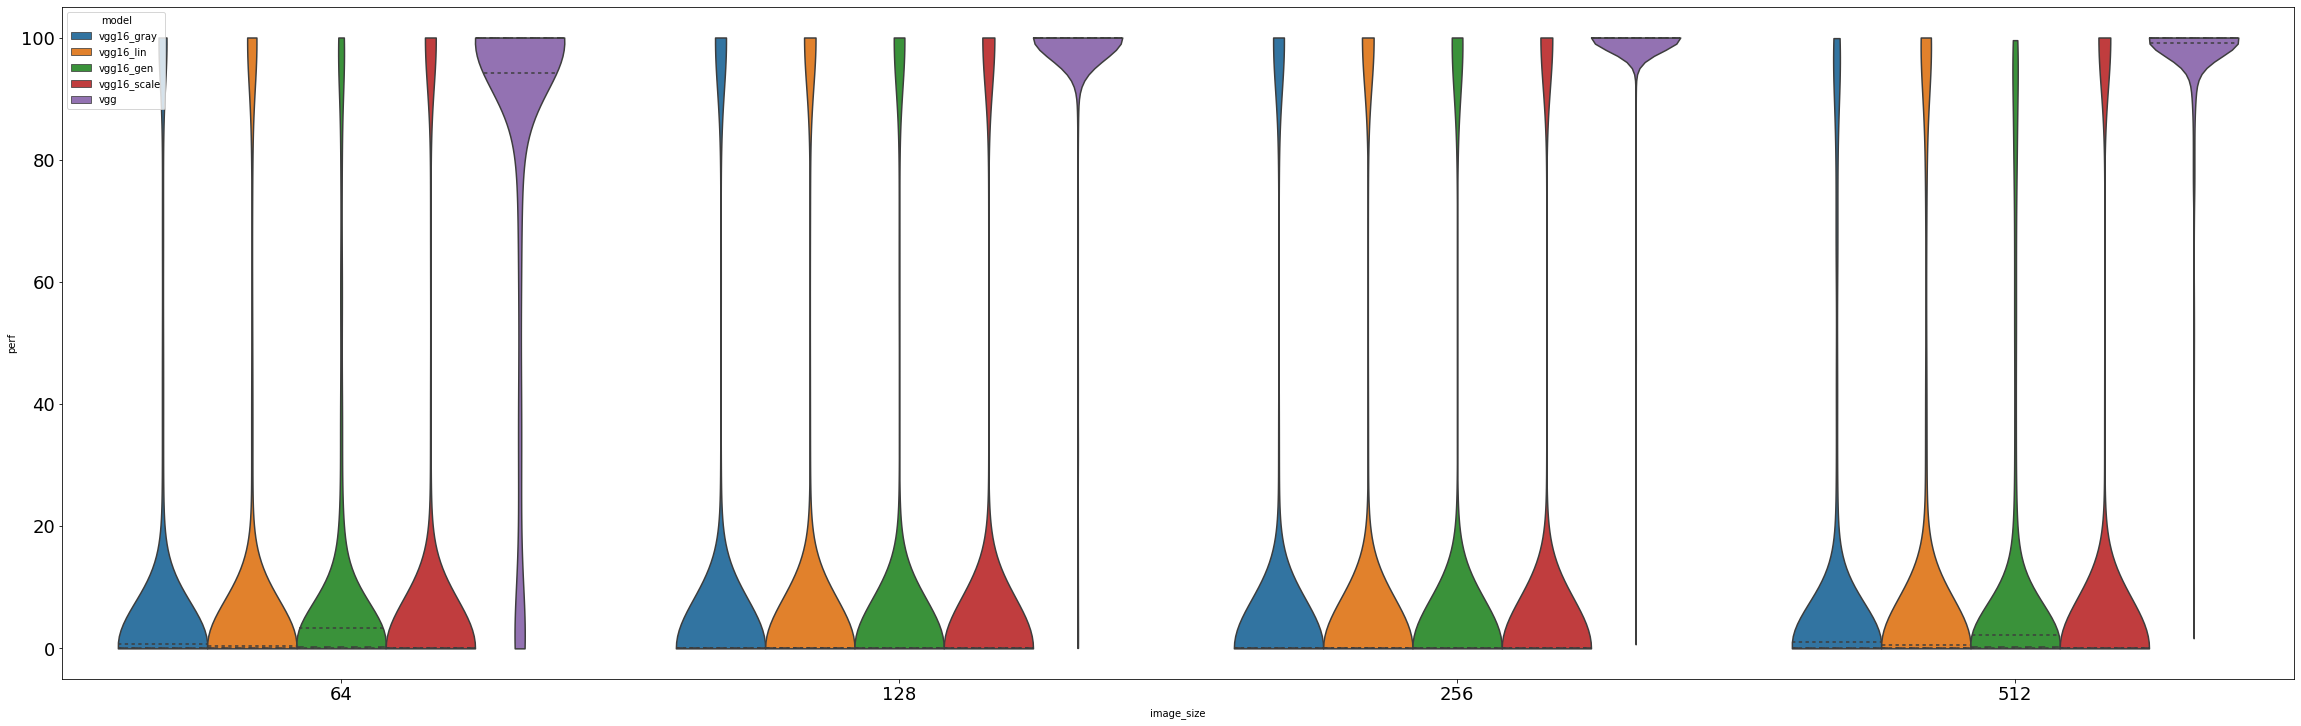

In [41]:
fig, axs = plt.subplots(figsize=(fig_width*2, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
axs = sns.violinplot(x="image_size", y="perf", data=df_downsample, inner="quartile", hue='model', cut = 0, scale = 'width')
axs.set_title('Processed on : ' + HOST + '_' + str(df_downsample['device'][0]), size=20)
axs.set_ylabel('Classification likelihood (%)', size=18)
axs.set_xlabel('Image size', size=18)
h, l = axs.get_legend_handles_labels()
axs.legend(h[:5], l[:5], loc ='center', fontsize=16);

#### Image display

The 64 worsts classification likelihood, all models and sizes combined : 

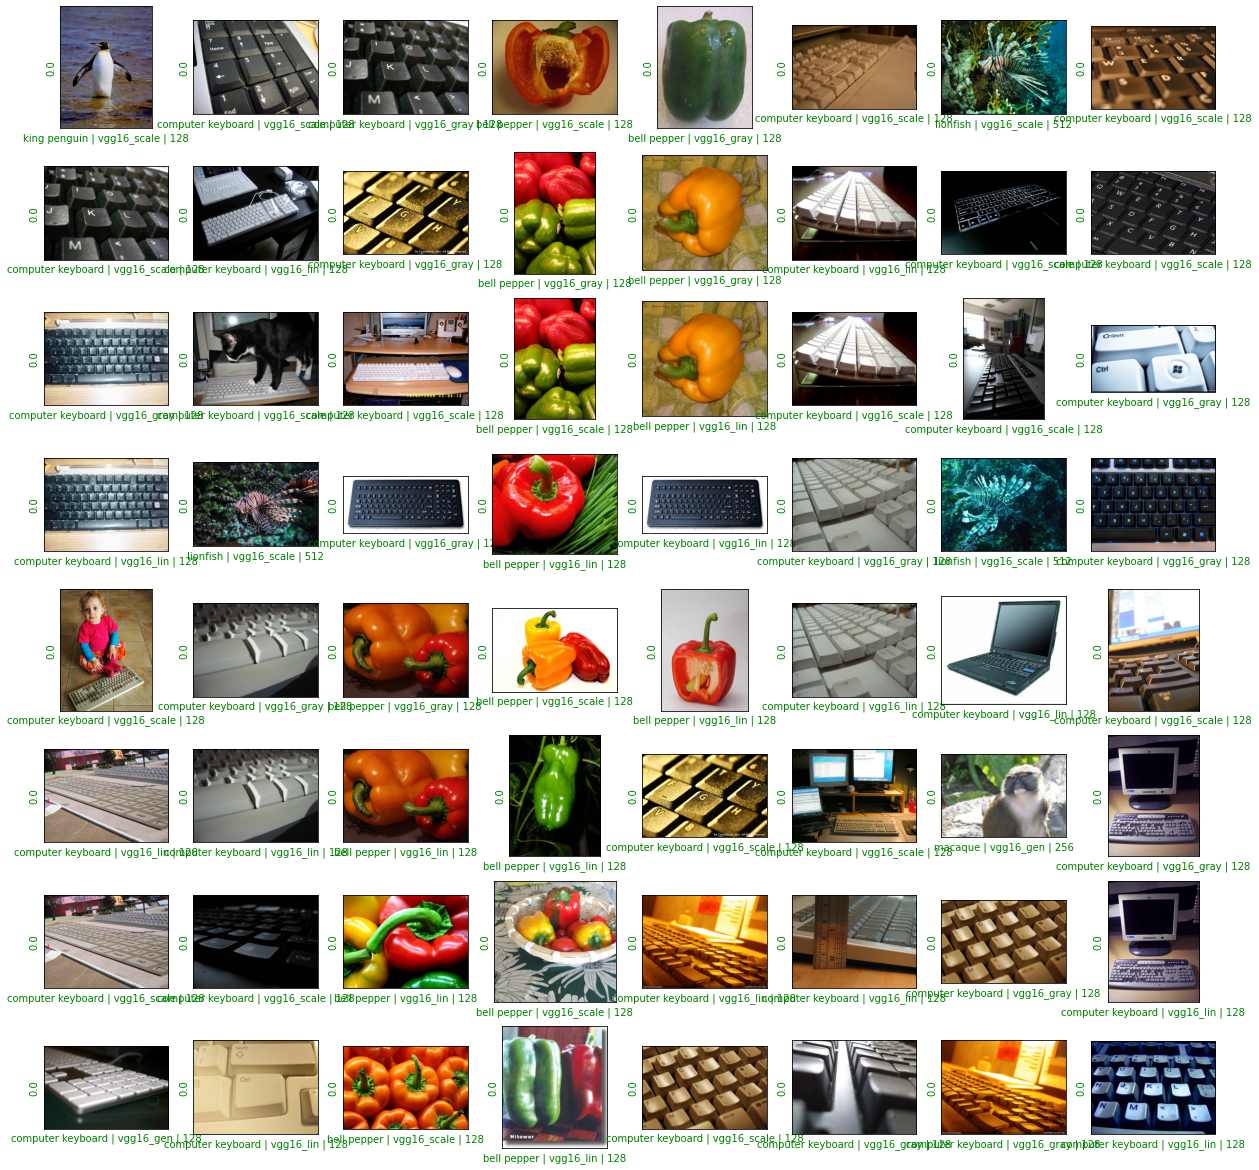

In [42]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(21, 21))
for i, idx in enumerate(df_downsample["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df_downsample.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_downsample.loc[idx]['label'] + ' | ' + df_downsample.loc[idx]['model']+ ' | ' + str(df_downsample.loc[idx]['image_size']), color='g')
    perf_ = df_downsample.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

## Mean

Again, we extracted a specific mean for each models : 

Classification likelihood's mean

In [43]:
for model_name in models.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["perf"])
        print(f'For size {image_size}, the mean clasification likelihood =  {med_perf:.5f} %' )

-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean clasification likelihood =  10.39738 %
For size 128, the mean clasification likelihood =  11.78974 %
For size 256, the mean clasification likelihood =  11.53777 %
For size 512, the mean clasification likelihood =  10.34561 %
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean clasification likelihood =  11.13568 %
For size 128, the mean clasification likelihood =  11.88241 %
For size 256, the mean clasification likelihood =  11.86548 %
For size 512, the mean clasification likelihood =  12.54113 %
----------------------------
Benchmarking model vgg16_gen
----------------------------
For size 64, the mean clasification likelihood =  10.09513 %
For size 128, the mean clasification likelihood =  11.52732 %
For size 256, the mean clasification likelihood =  11.45356 %
For size 512, the mean clasification likelihood =  10.479

Computation time 's mean

In [44]:
for model_name in models.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["time"])
        print(f'For size {image_size}, the mean  computation time =  {med_perf:.3f} s' )

-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean  computation time =  0.003 s
For size 128, the mean  computation time =  0.003 s
For size 256, the mean  computation time =  0.005 s
For size 512, the mean  computation time =  0.013 s
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean  computation time =  0.003 s
For size 128, the mean  computation time =  0.003 s
For size 256, the mean  computation time =  0.005 s
For size 512, the mean  computation time =  0.013 s
----------------------------
Benchmarking model vgg16_gen
----------------------------
For size 64, the mean  computation time =  0.003 s
For size 128, the mean  computation time =  0.003 s
For size 256, the mean  computation time =  0.005 s
For size 512, the mean  computation time =  0.013 s
------------------------------
Benchmarking model vgg16_scale
------------------------------
For size 64, the mean 

Frame per second's mean

In [45]:
for model_name in models.keys():
    pprint(f'Benchmarking model {model_name}')
    for image_size in image_sizes:
        med_perf = np.mean(df_downsample[(df_downsample['model']==model_name) & (df_downsample['image_size']==image_size)]["fps"])
        print(f'For size {image_size}, the mean fps  =  {med_perf:.3f} Hz' )

-----------------------------
Benchmarking model vgg16_gray
-----------------------------
For size 64, the mean fps  =  351.362 Hz
For size 128, the mean fps  =  340.820 Hz
For size 256, the mean fps  =  194.601 Hz
For size 512, the mean fps  =  79.148 Hz
----------------------------
Benchmarking model vgg16_lin
----------------------------
For size 64, the mean fps  =  332.518 Hz
For size 128, the mean fps  =  325.443 Hz
For size 256, the mean fps  =  188.903 Hz
For size 512, the mean fps  =  78.507 Hz
----------------------------
Benchmarking model vgg16_gen
----------------------------
For size 64, the mean fps  =  343.895 Hz
For size 128, the mean fps  =  336.429 Hz
For size 256, the mean fps  =  191.658 Hz
For size 512, the mean fps  =  78.410 Hz
------------------------------
Benchmarking model vgg16_scale
------------------------------
For size 64, the mean fps  =  345.960 Hz
For size 128, the mean fps  =  335.998 Hz
For size 256, the mean fps  =  189.996 Hz
For size 512, the me

# Experiment 3: Image processing and recognition on grayscale images :

Again, same likelihood indicators but now with a grayscale transformation.

In [78]:
scriptname = 'experiment_grayscale.py'

In [79]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_training_benchmark.model import *
filename = f'results/{datetag}_results_3_{HOST}.json'

# Output's set up
try:
    df_gray = pd.read_json(filename)
except:
    df_gray = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device', 'top_1']) 
    i_trial = 0
    
    # image preprocessing
    (dataset_sizes, dataloaders, image_datasets, data_transforms) = datasets_transforms(p=1)
    
    # Displays the input image of the model
    for i_image, (data, label) in enumerate(image_datasets['test']):
            for model_name in models.keys():
                model = models[model_name]
                model.eval()
                i_label_top = reverse_labels[image_datasets['test'].classes[label]]
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                if model_name == 'vgg' :
                    percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                    _, indices = torch.sort(out, descending=True)
                    top_1 = labels[indices[0]]
                    perf_ = percentage[reverse_i_labels[i_label_top]].item()
                else :
                    percentage = torch.nn.functional.softmax(out, dim=0) * 100
                    _, indices = torch.sort(out, descending=True)
                    top_1 = reverse_model_labels[indices[0]] 
                    perf_ = percentage[label].item()        
                dt = time.time() - tic            
                df_gray.loc[i_trial] = {'model':model_name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_datasets['test'].imgs[i_image][0], 'device':str(device), 'top_1':str(top_1)}
                print(f'The {model_name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds, best confidence for : {top_1}')
                i_trial += 1
    df_gray.to_json(filename)

Overwriting experiment_grayscale.py


In [ ]:
%run {scriptname}


Collecting all the results, displaying all the data in a table 

In [49]:
filename = f'results/{datetag}_results_3_{HOST}.json'
#filename = 'results/2021-04-20_results_3_INV-133-DE01.json'
df_gray = pd.read_json(filename)
df_gray

model        perf         fps      time            label  i_label  \
0      vgg16_gray   84.124771   47.838679  0.020904        albatross      146   
1       vgg16_lin   99.994003  181.242071  0.005517        albatross      146   
2       vgg16_gen   83.478569  188.457225  0.005306        albatross      146   
3     vgg16_scale  100.000000  196.362547  0.005093        albatross      146   
4             vgg   99.999405  180.516634  0.005540        albatross      146   
...           ...         ...         ...       ...              ...      ...   
4750   vgg16_gray    0.007063  231.154808  0.004326  vending machine      886   
4751    vgg16_lin    0.018595  223.172502  0.004481  vending machine      886   
4752    vgg16_gen    2.010380  227.914144  0.004388  vending machine      886   
4753  vgg16_scale    0.424194  231.601546  0.004318  vending machine      886   
4754          vgg   99.947014  210.261881  0.004756  vending machine      886   

      i_image                                           filename  device  \
0           0                     data/test/albatross/0712-2.jpg  cuda:0   
1           0                     data/test/albatross/0712-2.jpg  cuda:0   
2           0                     data/test/albatross/0712-2.jpg  cuda:0   
3           0                     data/test/albatross/0712-2.jpg  cuda:0   
4           0                     data/test/albatross/0712-2.jpg  cuda:0   
...       ...                                                ...     ...   
4750      950  data/test/vending machine/wine-vending-machine...  cuda:0   
4751      950  data/test/vending machine/wine-vending-machine...  cuda:0   
4752      950  data/test/vending machine/wine-vending-machine...  cuda:0   
4753      950  data/test/vending machine/wine-vending-machine...  cuda:0   
4754      950  data/test/vending machine/wine-vending-machine...  cuda:0   

                top_1  
0           albatross  
1           albatross  
2           albatross  
3           albatross  
4           albatross  
...               ...  
4750  vending machine  
4751  vending machine  
4752  vending machine  
4753  vending machine  
4754  vending machine  

[4755 rows x 10 columns]

## Accuracy, Precision, Recall

<ipython-input-50-c808b32579a7>:25: RuntimeWarning: invalid value encountered in long_scalars
  pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))


Text(0.5, 0, 'Models')

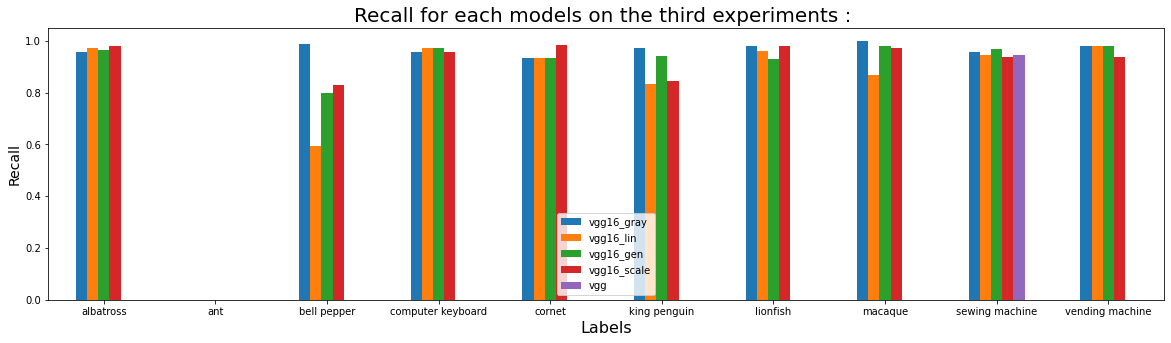

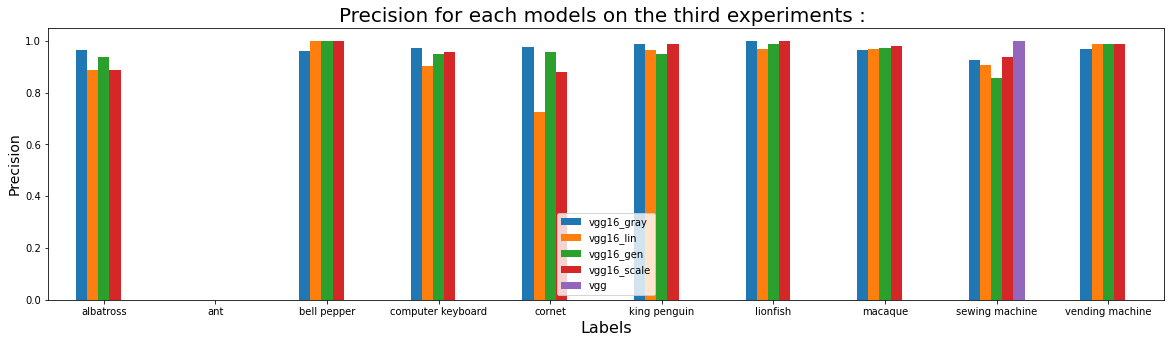

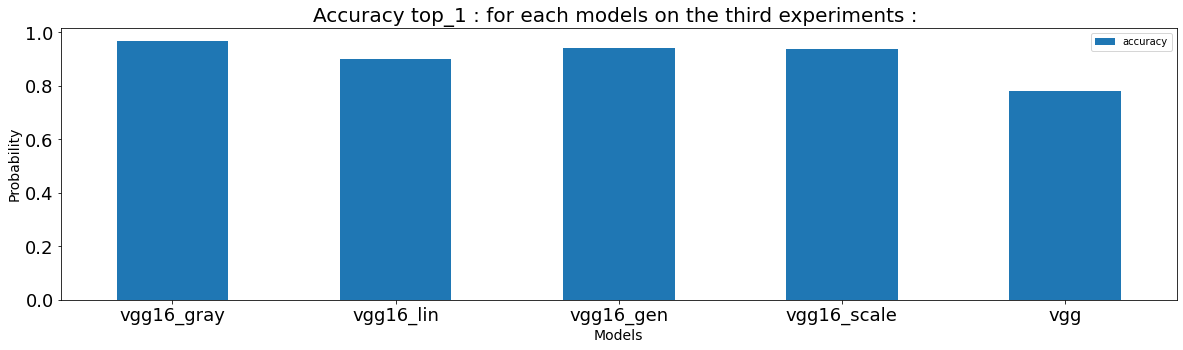

In [50]:
results = {} 
results['acc'] = []
results['precision'] = {}
results['recall'] = {}

for model_name in models.keys():
    #pprint('Model : ' + model_name)
    model_pred = df_gray[df_gray['model']==model_name]["top_1"].values.tolist()
    ground_true = df_gray[df_gray['model']==model_name]["label"].values.tolist()
    acc = sklearn.metrics.accuracy_score(ground_true, model_pred)
    results['acc'].append(acc)
    #print(f'Accuracy top_1 : {acc:.3f}')
    pres = multilabel_confusion_matrix(ground_true, model_pred)
    results['precision'][model_name] = []
    #pprint('Precision :')
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[-1][0]))
        results['precision'][model_name].append(pres_)
        #print(f'{pres_:.3f} for the label {label}')
    results['recall'][model_name] = []
    #pprint('Recall :')
    for i, label in zip(pres, reverse_model_labels) :
        pres_ = np.flip(i)
        pres_ = ((pres_[0][0]) / (pres_[0][0] + pres_[0][-1]))
        results['recall'][model_name].append(pres_)
        #print(f'{pres_:.3f} for the label {label}')

for mode in ['recall', 'precision']:
    df_acc = pd.DataFrame({'vgg16_gray': results[mode]['vgg16_gray'],
                        'vgg16_lin': results[mode]['vgg16_lin'],
                         'vgg16_gen': results[mode]['vgg16_gen'],
                          'vgg16_scale': results[mode]['vgg16_scale'],
                           'vgg': results[mode]['vgg'],
                      }, index=reverse_model_labels)
    ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 10)
    ax.set_title(mode.capitalize()+' for each models on the third experiments : ', size=20)
    ax.set_ylabel(mode.capitalize(), size= 14)
    ax.set_xlabel('Labels', size= 16)
df_acc = pd.DataFrame({'accuracy': results['acc']},
                  index = models.keys())
ax = df_acc.plot.bar(rot=0, figsize=(fig_width, fig_width//4), fontsize = 18)
ax.set_title('Accuracy top_1 : for each models on the third experiments : ', size=20)
ax.set_ylabel('Probability', size= 14)
ax.set_xlabel('Models', size= 14)

## Computation time

A display of the differents computation time of each models on the same dataset for a single resolution :

/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/lib/python3/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning

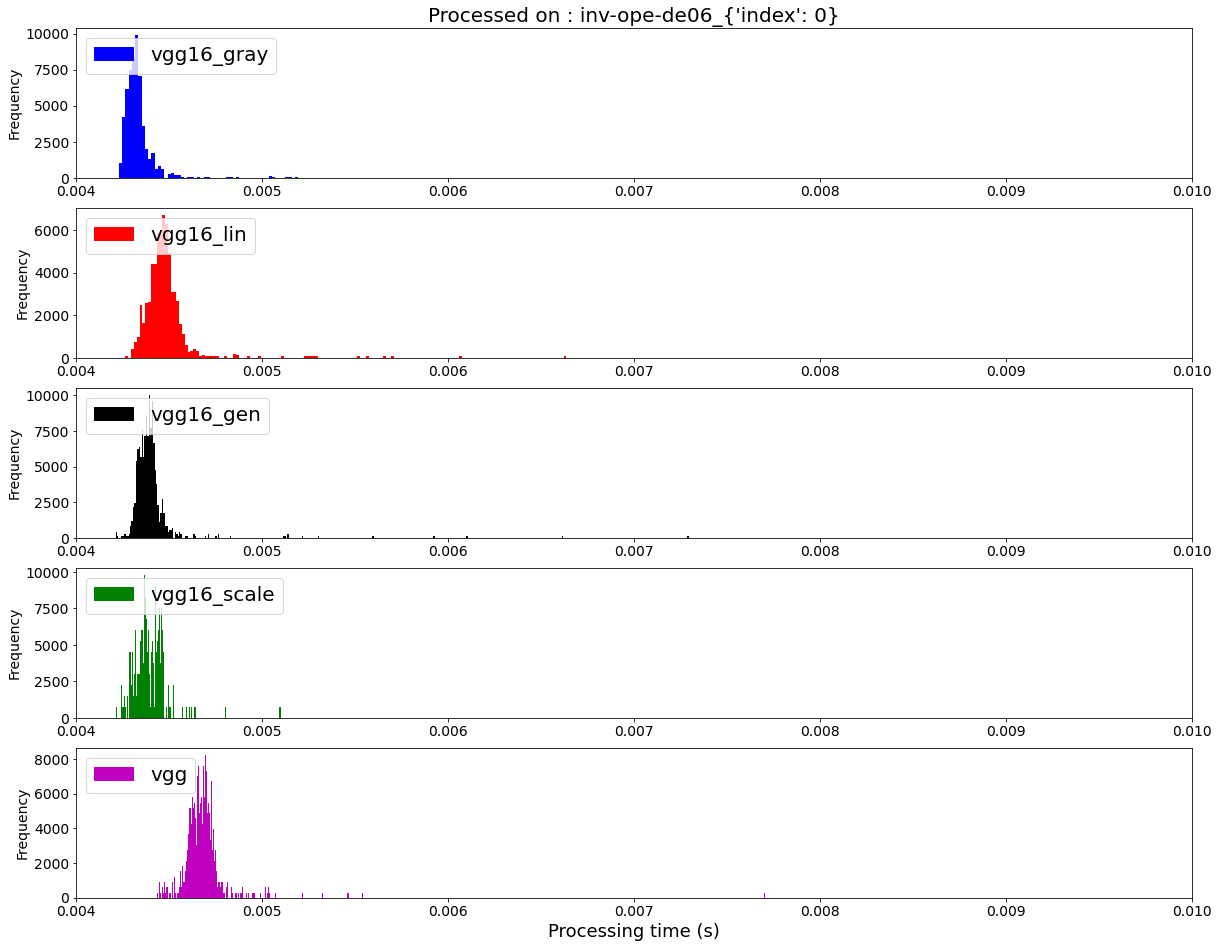

In [51]:
fig, axs = plt.subplots(len(models.keys()), 1, figsize=(fig_width, fig_width*phi//2))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df_gray[df_gray['model']==model_name]['time'].plot.hist(bins=len(df_gray[df_gray['model']==model_name]['time']), lw=1, label=model_name,ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize = 20)
    ax.set_xlim(0.004, 0.01)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Processing time (s)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + str(df['device'][0]), size = 20);

## Classification likelihood

A display of the classification likelihood of each models on the same dataset for a single resolution :

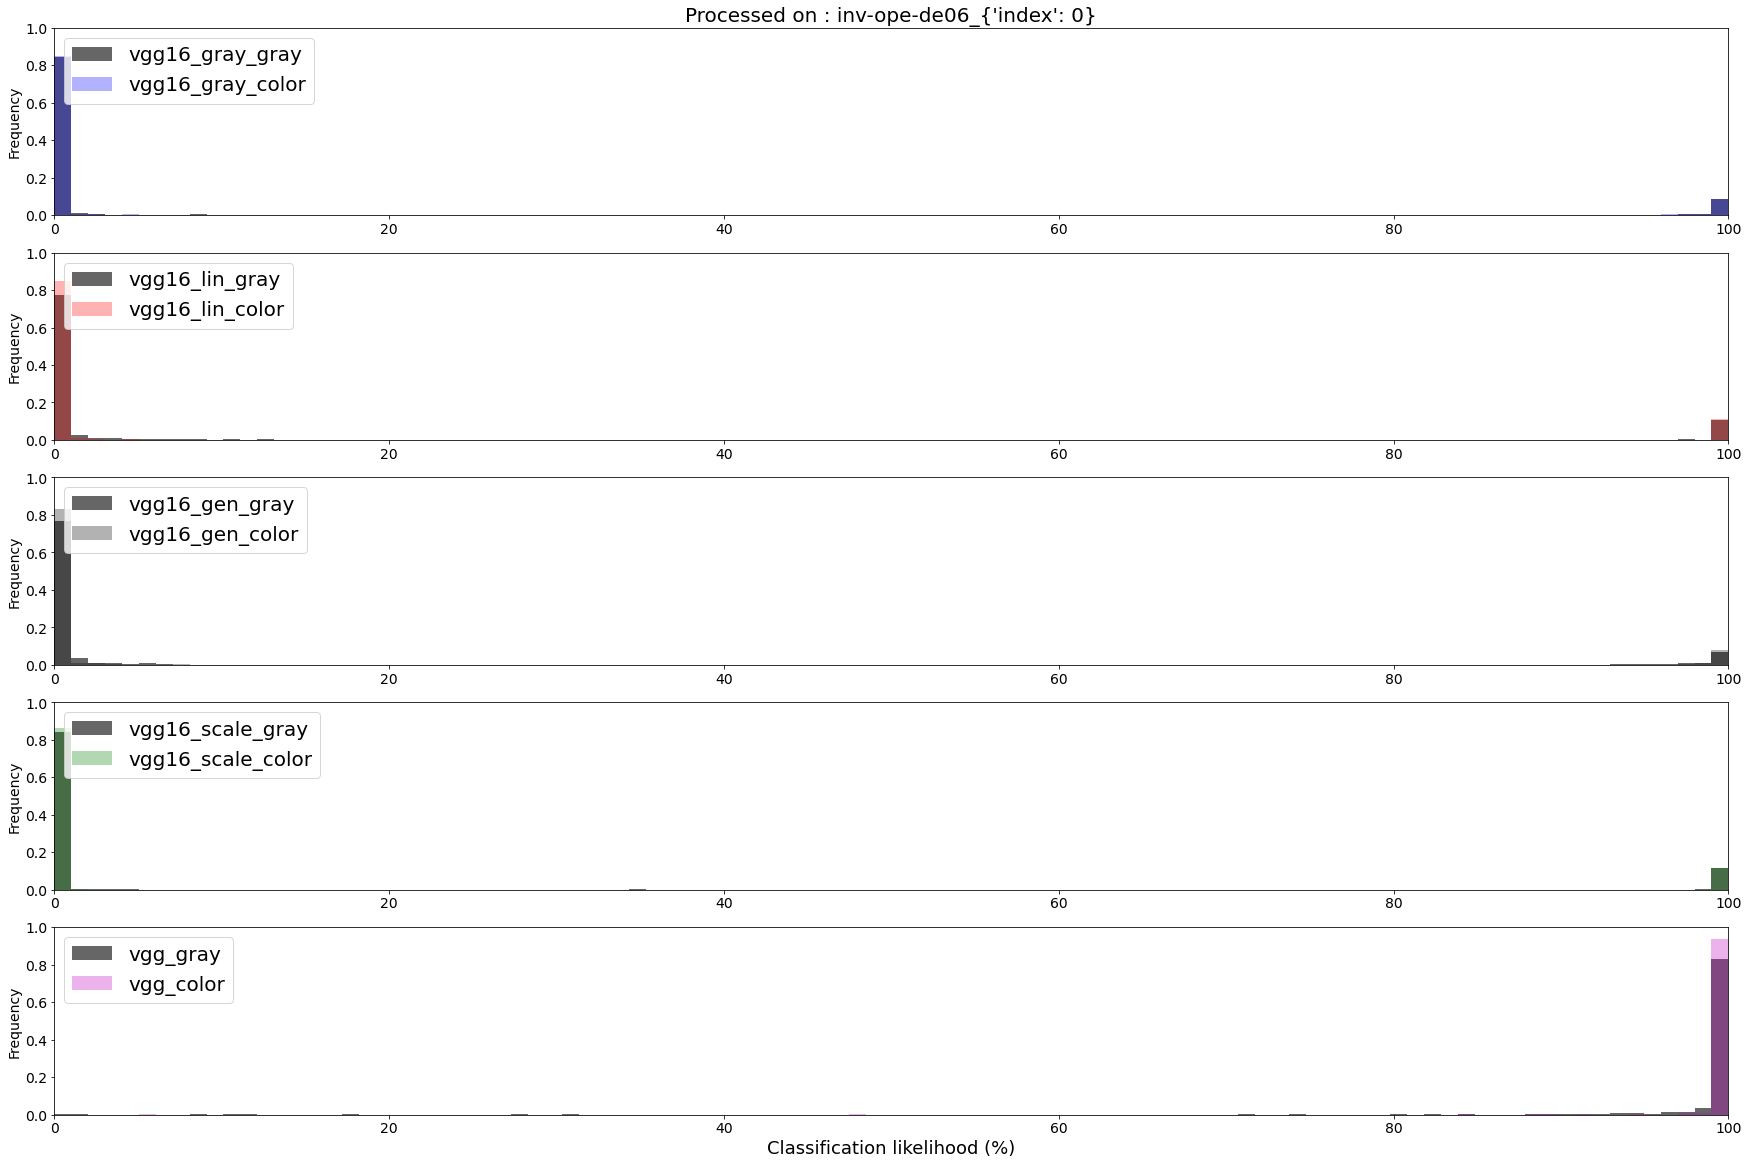

In [52]:
fig, axs = plt.subplots(len(models), 1, figsize=(30, 20))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for ax, color, model_name in zip(axs, colors, models.keys()):
    ax.set_ylabel('Frequency', fontsize=14)
    df_gray[df_gray['model']==model_name]['perf'].plot.hist(bins=np.linspace(0, 100, 100), lw=0, alpha=0.6, label=model_name + '_gray', ax=ax, color='k', density=True)
    df[df['model']==model_name]['perf'].plot.hist(bins=np.linspace(0, 100, 100), lw=0, alpha=0.3, label=model_name + '_color', ax=ax, color=color, density=True)
    ax.legend(loc='upper left', fontsize = 20)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Classification likelihood (%)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + str(df['device'][0]), size = 20);

## Image display

The 64 worsts classification likelihood, all model combined : 

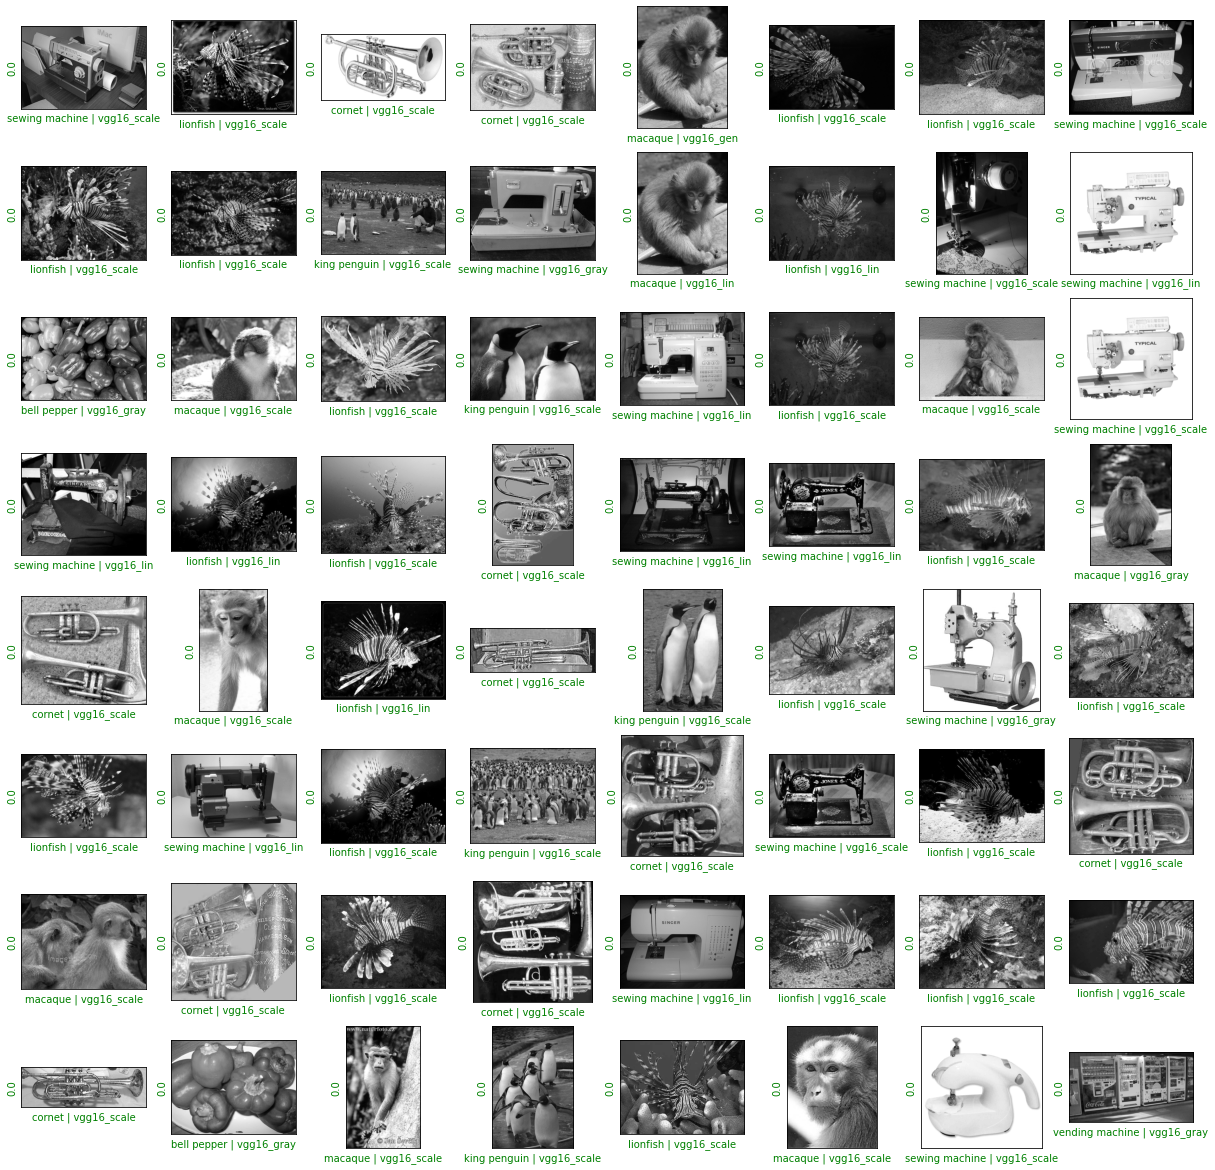

In [53]:
N_image_i = 8
N_image_j = 8

fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(21, 21))
for i, idx in enumerate(df_gray["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_datasets['test'].imgs[df_gray.loc[idx]['i_image']][0], pilmode="L"), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_gray.loc[idx]['label'] + ' | ' + df_gray.loc[idx]['model'], color='g')
    perf_ = df_gray.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

# Synthesis


## Computation time compared with experiment 1

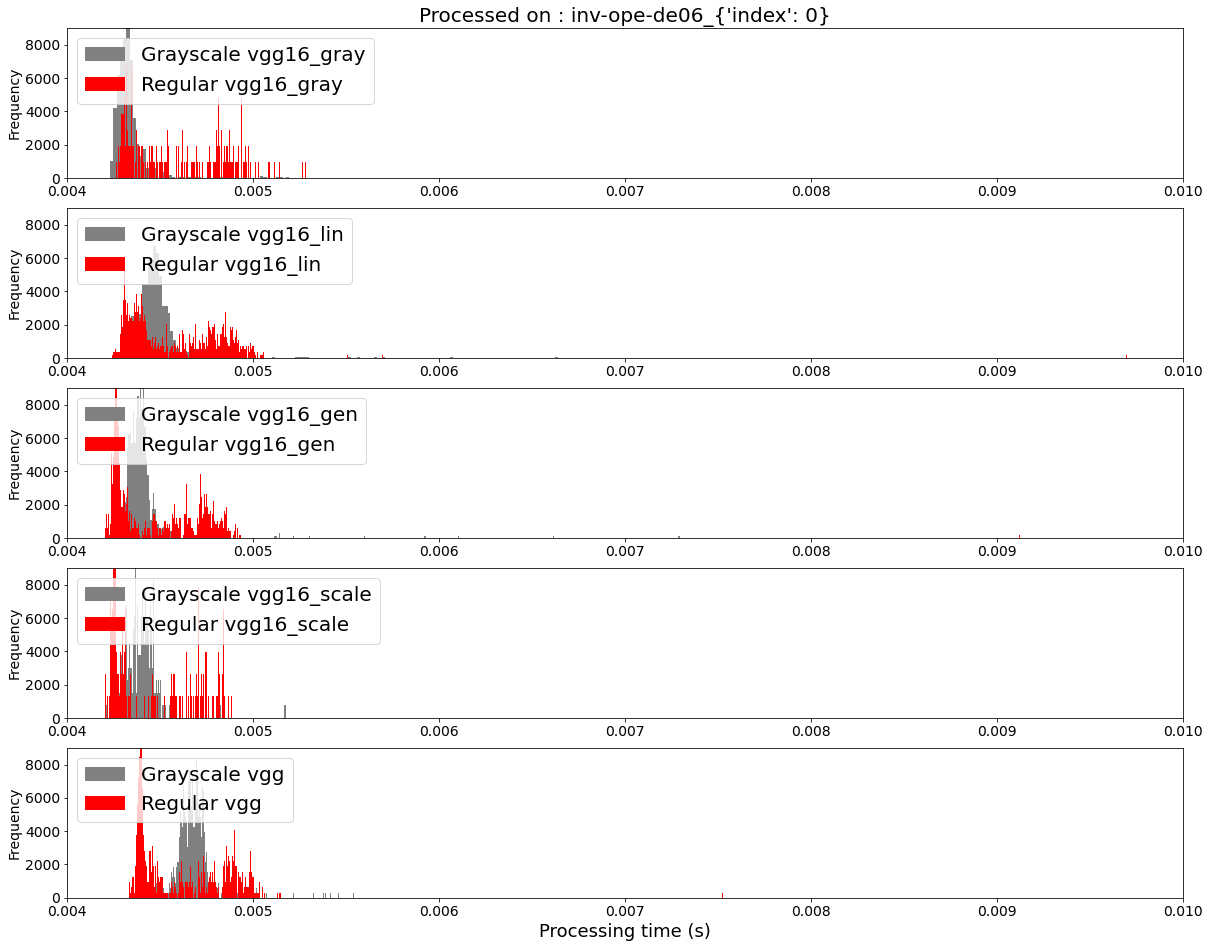

In [54]:
fig, axs = plt.subplots(len(models.keys()), 1, figsize=(fig_width, fig_width*phi//2))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, df_, label, legend in zip(['gray', 'red'], [df_gray, df], ['black', 'color'], ['Grayscale', 'Regular']):
    for ax, model_name in zip(axs, models.keys()):
        ax.set_ylabel('Frequency', fontsize=14) 
        df_[df_['model']==model_name]['time'].plot.hist(bins=len(df_[df_['model']==model_name]['time']), lw=1, label=str(legend+ ' ' + model_name), ax=ax, color=color, density=True)
        ax.legend(loc='upper left', fontsize = 20)
        ax.set_xlim(0.004, 0.01)
        ax.set_ylim(0, 9000)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
axs[-1].set_xlabel('Processing time (s)', size= 18)
axs[0].set_title('Processed on : ' + HOST + '_' + str(df['device'][0]), size = 20);

## Classification likelihood compared with experiment 1

Let's analyze the classification likelihood of each models on the same dataset for color versus grayscale images. Here likelihood's are displayed as a violin plot to allow a better representation of the models.

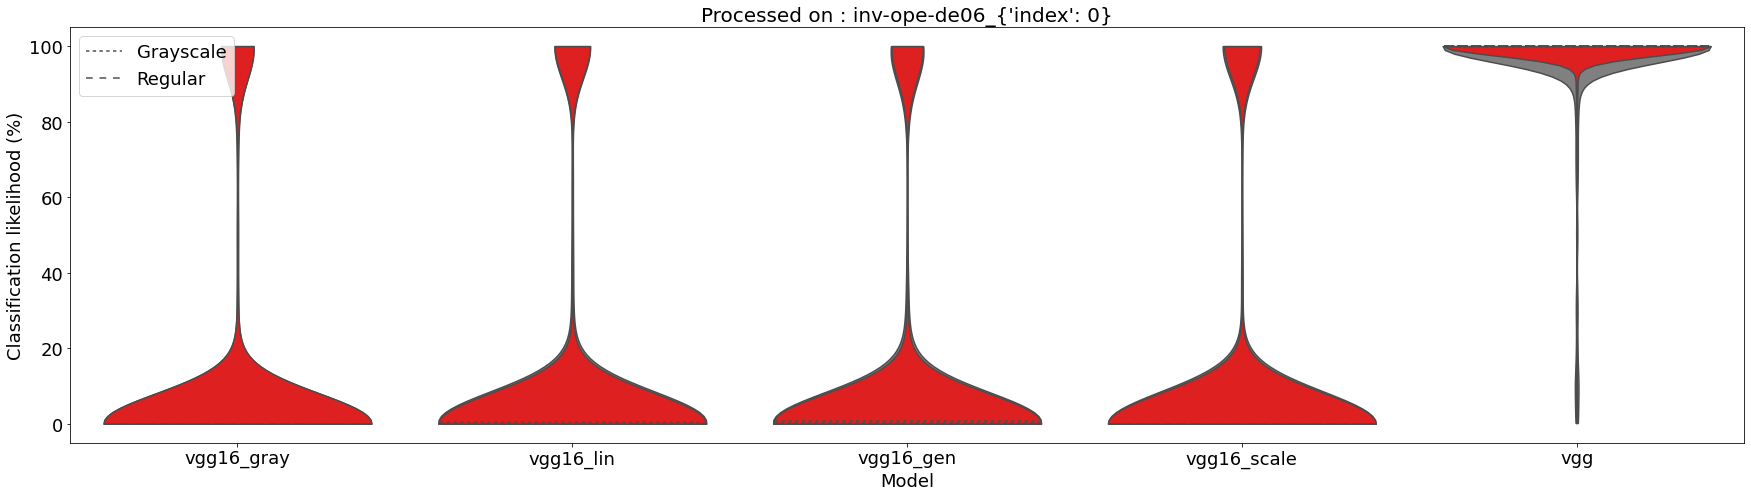

In [55]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi**2))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, df_, label in zip(['gray', 'red'], [df_gray, df], ['black', 'color']):
    axs = sns.violinplot(x="model", y="perf", data=df_, inner="quartile", cut=0, color=color, alpha=.5, scale = 'width')
    axs.set_title('Processed on : ' + HOST + '_' + str(df_['device'][0]), size=20)
    axs.set_ylabel('Classification likelihood (%)', size=18)
    axs.legend(['Grayscale', 'Regular'], fontsize=18)
    axs.set_xlabel('Model', size=18)

## Mean compared with experiment 1

Classification likelihood's mean

In [56]:
for model_name in models.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["perf"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["perf"])
    print(f'For the {model_name} model, the mean clasification likelihood = {med_perf:.5f} % (color =  {med_perf_orig:.5f} % )' )
    print(stats.ttest_1samp(df_gray[df_gray['model']==model_name]["perf"], np.mean(df[df['model']==model_name]["perf"])))

For the vgg16_gray model, the mean clasification likelihood = 11.54969 % (color =  11.49403 % )
Ttest_1sampResult(statistic=0.05525751433254024, pvalue=0.9559449276109053)
For the vgg16_lin model, the mean clasification likelihood = 12.62708 % (color =  11.84939 % )
Ttest_1sampResult(statistic=0.7492741829581993, pvalue=0.453877452445144)
For the vgg16_gen model, the mean clasification likelihood = 12.07050 % (color =  11.30018 % )
Ttest_1sampResult(statistic=0.7661842210515698, pvalue=0.4437570270748271)
For the vgg16_scale model, the mean clasification likelihood = 13.00960 % (color =  11.94580 % )
Ttest_1sampResult(statistic=0.9899403683583621, pvalue=0.32245533182926067)
For the vgg model, the mean clasification likelihood = 96.10521 % (color =  98.48818 % )
Ttest_1sampResult(statistic=-4.676006700217698, pvalue=3.348272536283438e-06)


Computation time 's mean

In [57]:
for model_name in models.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["time"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["time"])
    print(f'For the {model_name} model, the mean computation time  =  {med_perf:.4f} s  (color =  {med_perf_orig:.4f} s )' )

For the vgg16_gray model, the mean computation time  =  0.0044 s  (color =  0.0046 s )
For the vgg16_lin model, the mean computation time  =  0.0045 s  (color =  0.0046 s )
For the vgg16_gen model, the mean computation time  =  0.0044 s  (color =  0.0045 s )
For the vgg16_scale model, the mean computation time  =  0.0044 s  (color =  0.0045 s )
For the vgg model, the mean computation time  =  0.0047 s  (color =  0.0046 s )


Frame per second's mean

In [58]:
for model_name in models.keys():
    med_perf_orig = np.mean(df[df['model']==model_name]["fps"])
    med_perf = np.mean(df_gray[df_gray['model']==model_name]["fps"])
    print(f'For the {model_name} model, the mean fps  =  {med_perf:.3f} Hz (color =  {med_perf_orig:.3f} Hz )' )

For the vgg16_gray model, the mean fps  =  230.475 Hz (color =  219.225 Hz )
For the vgg16_lin model, the mean fps  =  222.965 Hz (color =  219.114 Hz )
For the vgg16_gen model, the mean fps  =  227.133 Hz (color =  223.691 Hz )
For the vgg16_scale model, the mean fps  =  227.412 Hz (color =  224.364 Hz )
For the vgg model, the mean fps  =  213.807 Hz (color =  216.853 Hz )
